In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable 
import time
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import cv2
import keras


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
if torch.cuda.is_available():
    dev= 'cuda:0'
else:
    dev = 'cpu'
torch.cuda.is_available()

True

In [3]:
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import pandas as pd


(240, 240, 155, 2)
[0. 1. 2. 3.]


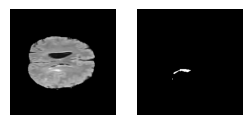

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmp76gzr1uf.PNG'


In [4]:
#/kaggle/input/task01braintumour/Task01_BrainTumour/imagesTr/BRATS_001.nii
i=1
train1 = nib.load(f"/kaggle/input/task01braintumour/Task01_BrainTumour/imagesTr/BRATS_{i:03}.nii")
train_data1 = train1.get_fdata()[:,:,:,0:2]
test1 = nib.load(f"/kaggle/input/task01braintumour/Task01_BrainTumour/imagesTr/BRATS_{i:03}.nii")
test_data1 =test1.get_fdata()
lab1 = nib.load(f"/kaggle/input/task01braintumour/Task01_BrainTumour/labelsTr/BRATS_{i:03}.nii")
lab_data = lab1.get_fdata()
print(train_data1.shape)
#classes
print(np.unique(lab_data))
fig, ax = plt.subplots(1,2, figsize=(3,3))
ax[0].imshow(train_data1[:,:,100,0], cmap="gray")
ax[1].imshow(lab_data[:,:,100], cmap="gray")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()
test = np.array(test_data1)
test1 = np.stack(test,axis=1)
test = Image.fromarray(lab_data[:,:,11])
test.show()
label1 = torch.zeros((240,240,240,4))
#label1[:,:,14,0] = torch.where(lab_data[:,:,14]==0, torch.tensor(1), torch.tensor(0))

71


Text(0.5, 1.0, 'showing tumor seg')

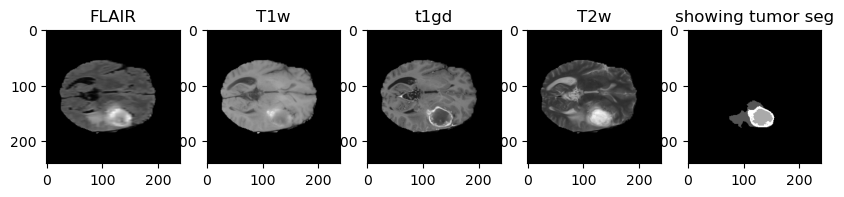

In [5]:
import random
#{'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'},
figure, (p1,p2,p3,p4,p5) = plt.subplots(1, 5,figsize =(10,20))
#choosing random slice....
rand_slice = random.randint(0,train_data1.shape[2])
print(rand_slice)
p1.imshow(test_data1[:,:,rand_slice,0],cmap = "gray")
p1.set_title("FLAIR")
p2.imshow(test_data1[:,:,rand_slice,1],cmap = "gray")
p2.set_title("T1w")
p3.imshow(test_data1[:,:,rand_slice,2],cmap = "gray")
p3.set_title("t1gd")
p4.imshow(test_data1[:,:,rand_slice,3],cmap = "gray")
p4.set_title("T2w")
# ploting segment of tumor
p5.imshow(lab_data[:,:,rand_slice],cmap="gray")
p5.set_title("showing tumor seg")

#we will use Flair and T1gd- 0,2

In [6]:
train_data_flair = train1.get_fdata()[:,:,:,0]
train_data_t1gd = train1.get_fdata()[:,:,:,2]

train_data1 = np.array(train_data_flair)
np.shape(train_data_flair)

(240, 240, 155)

In [7]:
path = "/kaggle/input/task01braintumour/Task01_BrainTumour"
list_path = os.listdir(path)
list_path.sort()
list_path


['dataset.json', 'imagesTr', 'imagesTs', 'labelsTr']

In [8]:
VOLUME_START_AT = 60 
VOLUME_SLICES = 75 

In [9]:
class Mydataset(Dataset):
    def __init__(self, path, list_path,img_size):
        super(Mydataset, self).__init__()
        self.path = path
        self.trainnum = list_path
        self.train = []
        self.train_path = []
        self.lab = []
        self.lab_path = []
        self.train_path = os.listdir(os.path.join(path,list_path[1]))
        self.train_path.sort()
        self.lab_path = os.listdir(os.path.join(path,list_path[3]))
        self.lab_path.sort()
        self.IMG_SIZE=img_size
        #print(self.train_path)
        
        
    def __len__(self):
        return len(self.train_path)
    
    def __getitem__(self,idx):
        img = nib.load(os.path.join(self.path,self.trainnum[1],self.train_path[idx]))
        #print(os.path.join(self.path,self.trainnum[1],self.train_path[idx]))
        img = img.get_fdata()
        img = np.array(img[:,:,:,[0,2]])
        img = np.float32(img)
        #img = torch.from_numpy(img)
        #img = transforms.ToPILImage(img)
        
        #img = Image.fromarray(img)
        
        label = nib.load(os.path.join(self.path,list_path[3],self.lab_path[idx]))
        label = label.get_fdata()
        label = np.array(label)
        #print(np.shape(label))
        #label = torch.from_numpy(label)
        #label = transforms.ToPILImage(label)
        #label =  Image.fromarray(label)
        
        #label = np.long(label)
        label = np.float32(label)
        
        update_img = np.zeros((self.IMG_SIZE, self.IMG_SIZE,75,2))
        update_lab = np.zeros((self.IMG_SIZE,self.IMG_SIZE,75))
        
        update_img[:,:,:,0] = cv2.resize(img[:,:,60:135,0], (self.IMG_SIZE,self.IMG_SIZE))
        update_img[:,:,:,1] = cv2.resize(img[:,:,60:135,1], (self.IMG_SIZE, self.IMG_SIZE))
        update_lab[:,:,:] = cv2.resize(label[:,:,60:135],(self.IMG_SIZE,self.IMG_SIZE))
        update_img = torch.Tensor(np.einsum("ijkl -> lijk",update_img))
        update_lab=np.float32(update_lab)
        label = torch.from_numpy(update_lab)
        update_img = np.float32(update_img)
        update_img = torch.from_numpy(update_img)
        label1 = torch.zeros((self.IMG_SIZE,self.IMG_SIZE,75,4))
        #print(label1.size())
        #one one hot encoding 
        label1[:,:,:,0] = torch.where(label[:,:,:]==0, torch.tensor(1), torch.tensor(0))
        label1[:,:,:,1] = torch.where(label[:,:,:]==1, torch.tensor(1), torch.tensor(0))
        label1[:,:,:,2] = torch.where(label[:,:,:]==2, torch.tensor(1), torch.tensor(0))
        label1[:,:,:,3] = torch.where(label[:,:,:]==3, torch.tensor(1), torch.tensor(0))
        label1 = torch.Tensor(np.einsum("ijkl->lijk",label1.numpy()))

        #Resizing images.
        
        return (update_img, label1)
                
                

    
                       
                          
                       
    
        
            


In [10]:
data = Mydataset(path, list_path,128)
np.shape(data[1][1])
type(data[1][1])

torch.Tensor

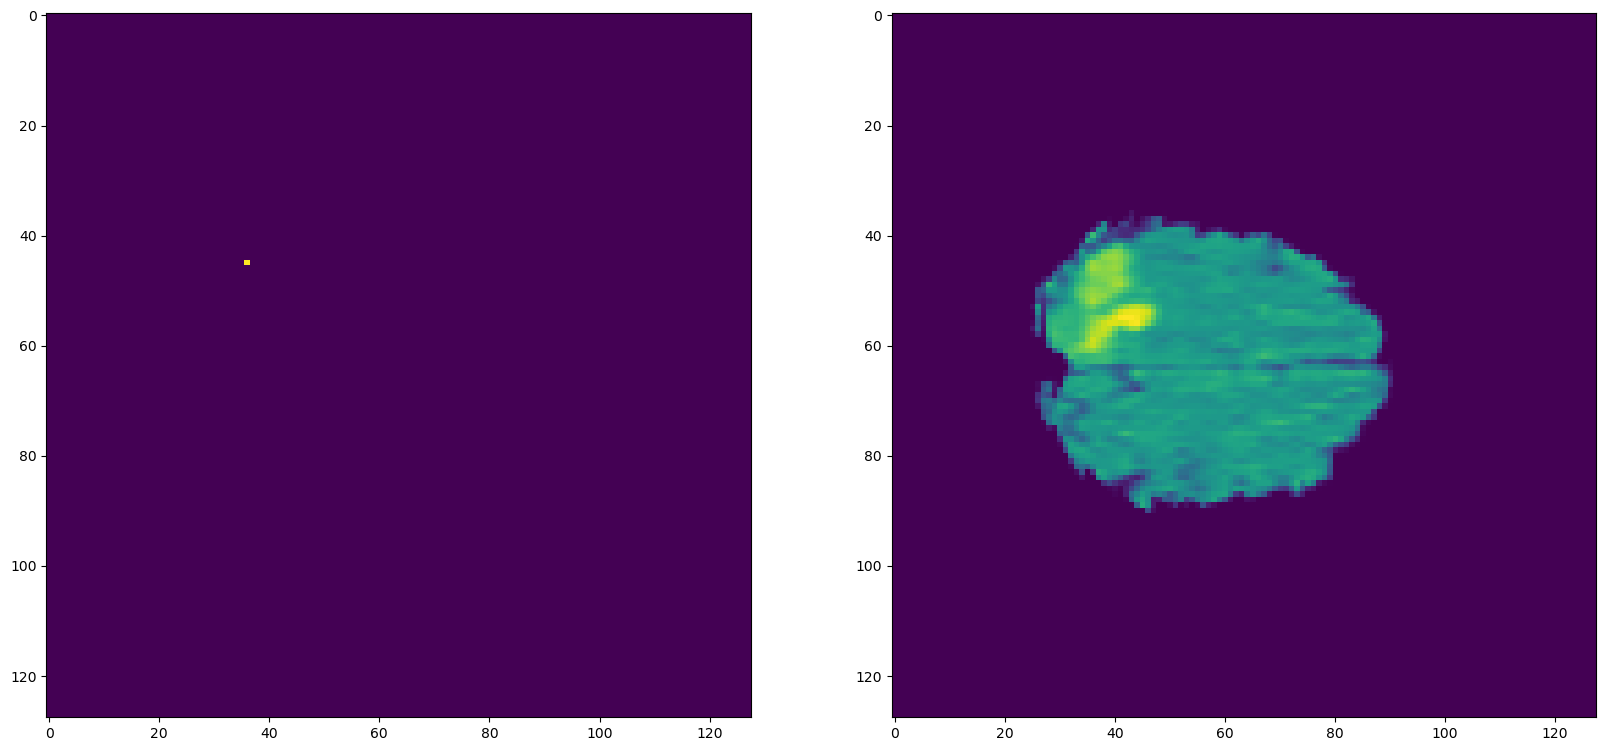

In [11]:
test_lab= data[1][1].cpu()
img = data[1][0].cpu()
hi = tf.one_hot(lab_data,4)

#test_lab = np.array(test_lab)
#test_lab = Image.fromarray(test_lab[:,:,90,2])
fig,ax= plt.subplots(1,2,figsize=(20,20))
#after one one hot encoding
ax[0].imshow(test_lab[2,:,:,60])
ax[1].imshow(img[0,:,:,60])
#plt.plot(lab_data[:,:,120])
plt.show()

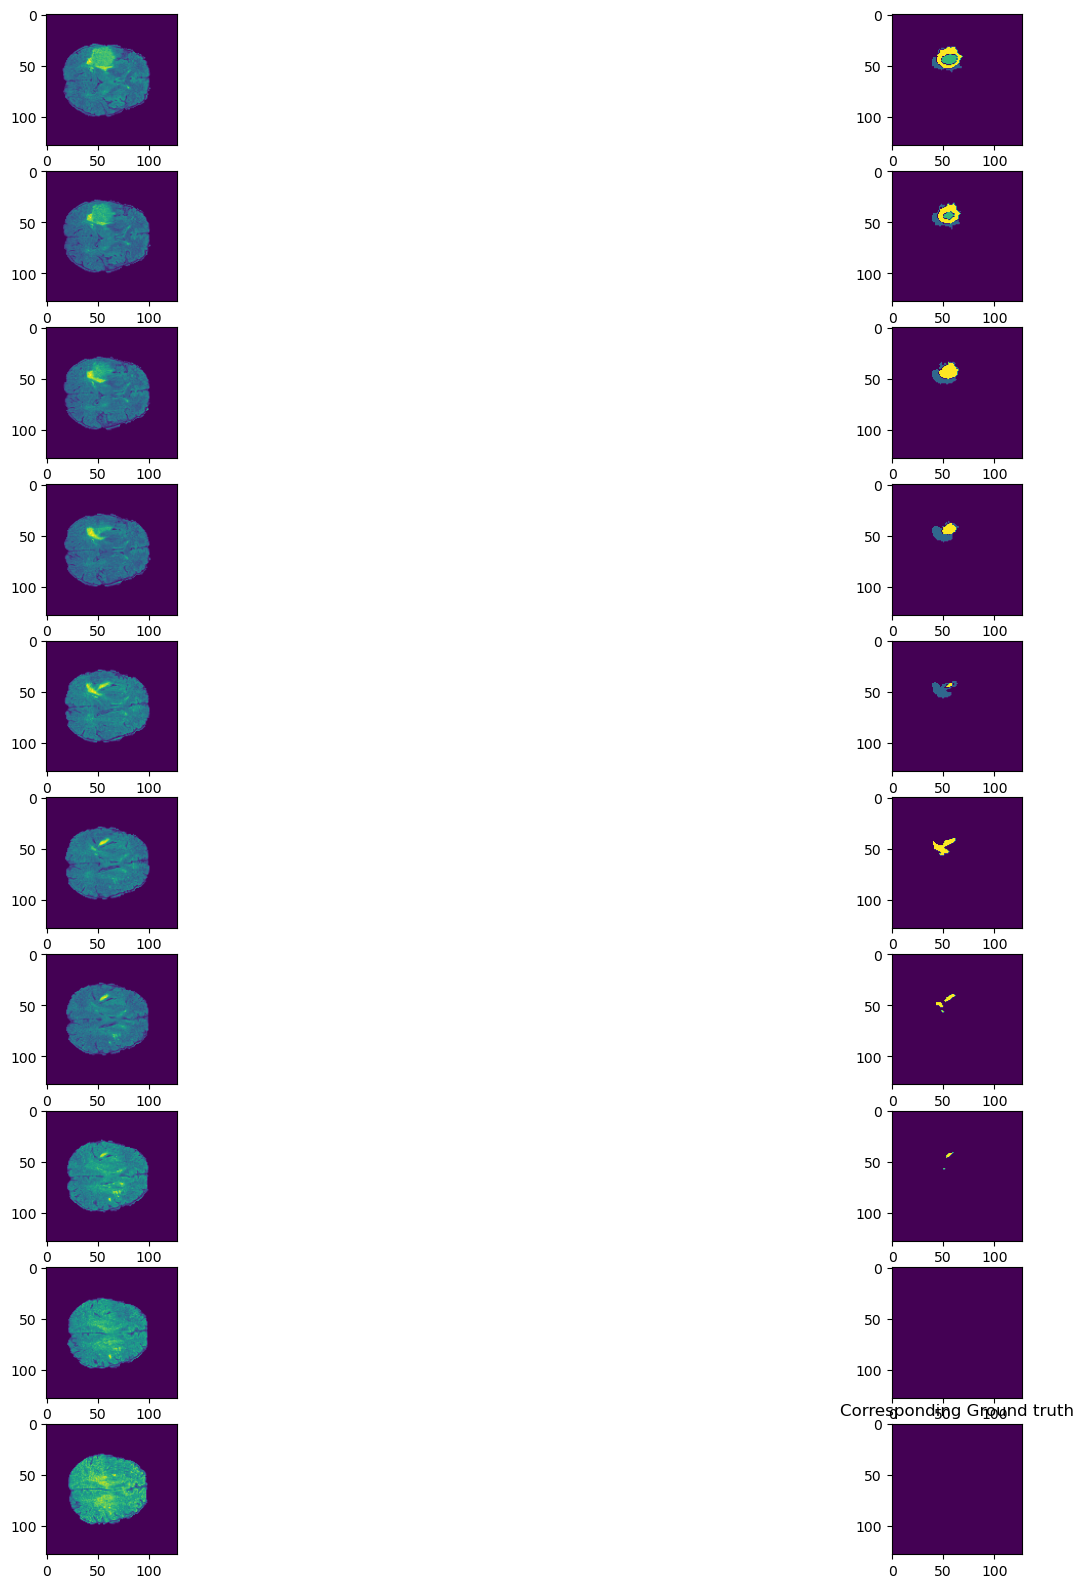

In [12]:
#t_path = os.path.join(path,list_path)


k=20
i=0
fig,ax = plt.subplots(10,2,figsize=(20,20))
for i in range(0,10):
   
    img = data[432][0].cpu()
    plt.title("Brain MRI Scans")
    ax[i,0].imshow(img[0,:,:,k])
    lab = data[432][1].cpu()
    store = np.argmax(lab.numpy(),axis=0)
    plt.title("Corresponding Ground truth")
    ax[i,1].imshow(store[:,:,k])
    k=k+2


In [13]:
#split the data into train and test-
train_size = int(0.018 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])
print(len(train_data))
print(len(test_data))

8
476


In [14]:
train_dl =  DataLoader(train_data, batch_size=4, shuffle=True, pin_memory=False, drop_last=False)
print(len(train_dl))
test_dl = DataLoader(test_data, batch_size=2, shuffle=True, pin_memory=False, drop_last=False)
print(len(test_dl))
train_dl

2
238


In [15]:
for batch in train_dl:
    image, lable = batch
    print(np.shape(image))
    print(np.shape(lable))
    
    break

torch.Size([4, 2, 128, 128, 75])
torch.Size([4, 4, 128, 128, 75])


In [16]:
# 2D U-Net
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2,2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        #print(np.shape(inputs))
        #print(np.shape(skip))
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x
    
class unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(2, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 4, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)
        

        return outputs

In [17]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [18]:
#!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:32

In [19]:
model = unet()
#model.to(dev)

In [20]:
import gc

gc.collect()

torch.cuda.empty_cache()
print(torch.cuda.mem_get_info())

(1100742656, 15843721216)


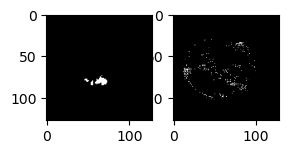

torch.Size([4, 128, 128])


In [21]:
#if USE_GPU and torch.cuda.is_available():
#for batch in train_dl:
#for batch in train_dl:
img, lable = batch
out = model(img[:,:,:,:,1])
pred_out = F.softmax(out,dim=1)
pred_out = torch.where(pred_out>=0.5, torch.tensor(1), torch.tensor(0))
pred_out= torch.argmax(pred_out,dim=1)
fig, ax = plt.subplots(1,2, figsize=(3,3))
ax[0].imshow(lable[1,1,:,:,1],cmap="gray")
ax[1].imshow(pred_out[1,:,:].detach().numpy(),cmap="gray") 
plt.show()
print(np.shape(pred_out))
#print(np.shape(label_slice))
#break


In [22]:
#Dice is also working fine-
# def calculate_dice(pred , targets):
#         smooth = 1.
        
#         # inputs = F.softmax(pred, dim=1) 
#         inputs = pred   
           
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         intersection = (inputs * targets).sum()                            
#         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
#         return 1 - dice

def calculate_dice(ground_truth, prediction):
    smooth=1e-5
    ground_truth = torch.from_numpy(np.argmax(ground_truth.cpu().numpy(),axis=1)).numpy()
    prediction = torch.from_numpy(np.argmax(prediction.cpu().numpy(),axis=1)).numpy()
    intersection = np.logical_and(ground_truth, prediction)
    dice_coefficient = 2 * np.sum(intersection)/ (np.sum(ground_truth) + np.sum(prediction)+smooth)
    return dice_coefficient


In [23]:
# def cal_iou(pred, target):
#     smooth = 1e-5
#     target = torch.from_numpy(np.argmax(target.cpu().numpy(),axis=1))
#     pred = torch.from_numpy(np.argmax(pred.cpu().numpy(),axis=1))
#     intersection = (pred * target).sum(dim=(1,2))
#     union = (pred + target).sum(dim=(1,2))
#     iou = (intersection + smooth) / (union - intersection + smooth)
#     return iou.mean()
def cal_iou(ground_truth, prediction):
    smooth=1e-5
    ground_truth = torch.from_numpy(np.argmax(ground_truth.cpu().numpy(),axis=1)).numpy()
    prediction = torch.from_numpy(np.argmax(prediction.cpu().numpy(),axis=1)).numpy()
    intersection = np.logical_and(ground_truth, prediction)
    union = np.logical_or(ground_truth, prediction)
    iou = (np.sum(intersection))/ (np.sum(union)+smooth)
    return iou

In [24]:
# def cal_accuracy(pred, target):
#     target = torch.from_numpy(np.argmax(target.cpu().numpy(),axis=1))
#     pred = torch.from_numpy(np.argmax(pred.cpu().numpy(),axis=1))
#     correct = pred.eq(target).sum()
#     acc = correct.float() / pred.numel()
#     return acc
def cal_accuracy(ground_truth, prediction):
    smooth=1e-5
    ground_truth = torch.from_numpy(np.argmax(ground_truth.cpu().numpy(),axis=1)).numpy()
    prediction = torch.from_numpy(np.argmax(prediction.cpu().numpy(),axis=1)).numpy()
    total_pixels = np.prod(ground_truth.shape)
    correct_pixels = np.sum(ground_truth == prediction)
    accuracy = (correct_pixels)/(total_pixels+smooth)
    return accuracy

In [25]:
lr = 0.001
epochs = 2
# Choosing the loss function to be Mean Square Error Loss
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
#write learning rate scheduler code for cylcic learning rate-
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [26]:
# No of Batches of size 4*75
len(train_dl)

2

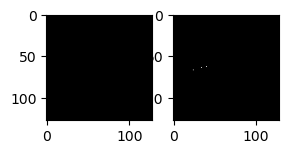

Accuracy 0.9668680825347593
IOU per batch 0.05706536250169119
dice cofficient 0.06395039029129436


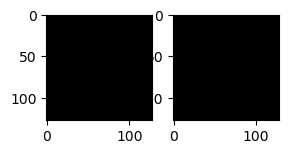

Accuracy 0.9843210854617837
IOU per batch 0.051514455568576145
dice cofficient 0.06773126139896618
Epoch: 1/2 | Training Time: 1.8632345120112102 | Training Loss: 1.0761444449424744 | Training Accuracy: 0.9755945839982713 | Training Jaccard: 0.05428990903513366 | Training Dice: 0.06584082584513025
Epoch got completed


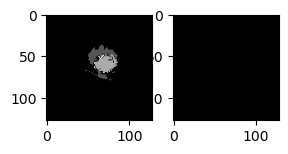

Accuracy 0.9783813475069608
IOU per batch 0.054582802787341164
dice cofficient 0.07237316607949876


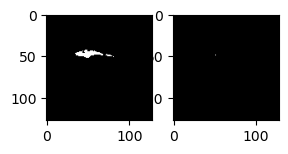

Accuracy 0.9941263833118499
IOU per batch 0.007758849688812314
dice cofficient 0.01407915962496975
Epoch: 2/2 | Training Time: 1.755810550848643 | Training Loss: 0.32853510479132336 | Training Accuracy: 0.9862538654094053 | Training Jaccard: 0.031170826238076734 | Training Dice: 0.04322616285223425
Epoch got completed


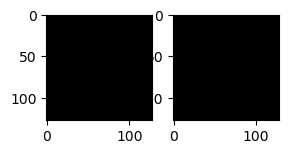

Accuracy 0.9890248615027325
IOU per batch 0.0006721626319380665
dice cofficient 0.0009159928681815595


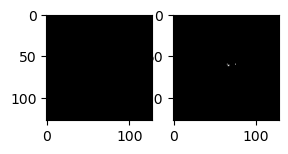

Accuracy 0.9855743406699257
IOU per batch 0.18069968481529947
dice cofficient 0.23185794315922237
Epoch: 3/2 | Training Time: 1.727078135808309 | Training Loss: 0.17332858641942342 | Training Accuracy: 0.9872996010863294 | Training Jaccard: 0.09068592372361878 | Training Dice: 0.11638696801370196
Epoch got completed


In [27]:
# Training only on 1.8% of train dataset, only for slices-10:25, on 2 epochs as dummy model to check working of model
# 
try :
    import logging
    logging.basicConfig(filename='training.log', level=logging.INFO)
    train_loss = []
    train_acc = []
    train_jacc = []
    train_dice = []
    model.train()

    for e in range(epochs+1):
        start = time.time()
        epoch_loss = 0
        epoch_acc = 0
        epoch_iou = 0
        epoch_dice = 0


        for batch in train_dl:
            batch_loss =0
            batch_acc =0
            batch_iou=0
            batch_dice=0
            img, label = batch
            img = img.float()
            for i in range(10,25):
                pred = model(img[:,:,:,:,i])
               # print(i)
               # print(np.shape(pred))
                #print(np.shape(label))
                label_slice = (label[:,:,:,:,i].float())
                #print(np.shape label_slice))
                #keep pred in cpu to calculate loss
                pred = pred.cpu()
                img = img.cpu()
                #print(np.shape(pred))

                loss = criteria(pred, torch.from_numpy(np.argmax(label_slice.cpu().numpy(),axis=1)))
                pred = F.softmax(pred, dim=1)
              #put 1 if elements of pred is greater than 0.5 else 0
                pred = torch.where(pred>=0.5, torch.tensor(1), torch.tensor(0))

                acc = cal_accuracy(pred, label_slice)
                #print(acc)
                iou = cal_iou(pred, label_slice)
                dice = calculate_dice(pred, label_slice)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                batch_loss += loss.item()
                batch_acc += acc
                batch_iou += iou
                batch_dice += dice

                epoch_loss += loss.item()
                epoch_acc += acc
                epoch_iou += iou
                epoch_dice += dice

            fig, ax = plt.subplots(1,2, figsize=(3,3))
            ax[0].imshow(np.argmax(label_slice.cpu().numpy(),axis=1)[1,:,:], cmap="gray")
            ax[1].imshow(np.argmax(pred.cpu().numpy(),axis=1)[1,:,:], cmap="gray")
            plt.show()
            print("Accuracy",batch_acc/15)
            print("IOU per batch",batch_iou/15)
            print("dice cofficient",batch_dice/15)
        scheduler.step()
        end = time.time()
        training_time = (end - start)/60
        train_loss.append(epoch_loss/(len(train_dl)*15))
        train_acc.append(epoch_acc/(len(train_dl)*15))
        train_jacc.append(epoch_iou/(len(train_dl)*15))
        train_dice.append(epoch_dice/(len(train_dl)*15))

        print("Epoch: {}/{} | Training Time: {} | Training Loss: {} | Training Accuracy: {} | Training Jaccard: {} | Training Dice: {}".format(e+1, epochs, training_time, epoch_loss/(len( train_dl)*15), epoch_acc/(len( train_dl)*15), epoch_iou/(len( train_dl)*15), epoch_dice/(len( train_dl)*15)))
        print("Epoch got completed")
       # logging.warning("Epoch: {}/{} | Training Time: {} | Training Loss: {} | Training Accuracy: {} | Training Jaccard: {} | Training Dice: {}".format(e+1, epochs, training_time, epoch_loss/len(train_dl), epoch_acc/len(train_dl), epoch_iou/len(train_dl), epoch_dice/len(train_dl)))
        if e%2 == 0:    
            torch.save(model.state_dict(), "deeplabv3_model_{}.pth".format(e+1))
except : 
    print("alert! got error")
    pass
        #plot the labels and predictions-
#     #if e%10 == 0:
#     for i in range(4):
#         fig, ax = plt.subplots(1,2, figsize=(3,3))
#         ax[0].imshow(lable[0,i,:,:], cmap="gray")
#         ax[0].set_title("Ground Truth")
#         ax[1].imshow(pred[0,i,:,:].detach().numpy(), cmap="gray")
#         ax[1].set_title("Prediction")
#         [axi.set_axis_off() for axi in ax.ravel()]
#         plt.show()
#     #     torch.save(model.state_dict(), "model_{}.pth".format(e+1))
    #     #plot the labels and predictions
    #     fig, ax = plt.subplots(1,2, figsize=(3,3))
    #     ax[0].imshow(label[0][1], cmap="gray")
    #     ax[1].imshow(pred[0][1].detach().numpy(), cmap="gray")
    #     [axi.set_axis_off() for axi in ax.ravel()]
    #     plt.show()

#model.train()

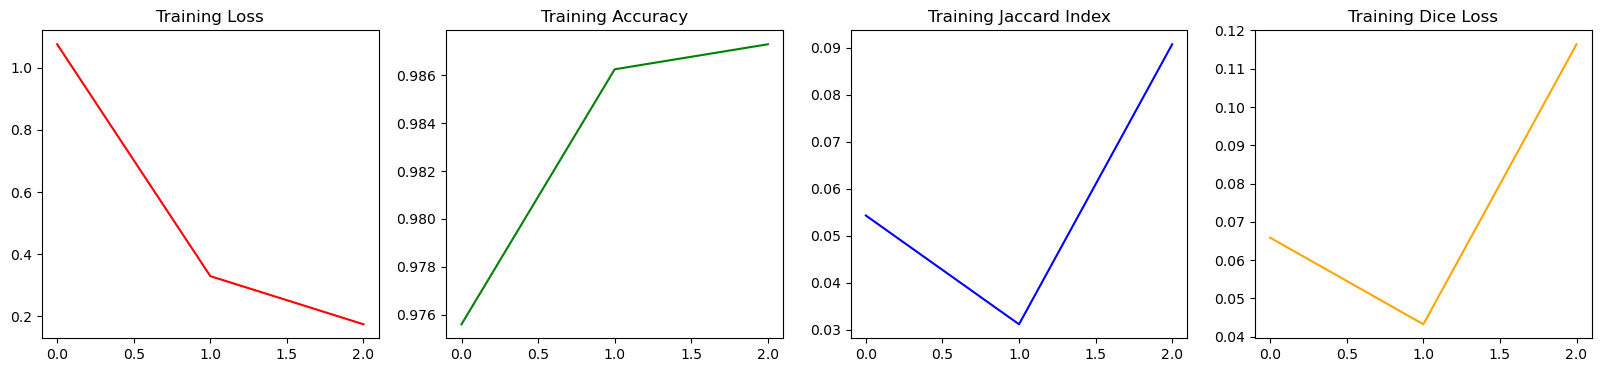

In [28]:
#  Based on above dummy model
fig,ax = plt.subplots(1,4, figsize=(20,4))
ax[0].plot(train_loss, color="red")
ax[0].set_title("Training Loss")
ax[1].plot(train_acc, color="green")
ax[1].set_title("Training Accuracy")
ax[2].plot(train_jacc, color="blue")
ax[2].set_title("Training Jaccard Index")
ax[3].plot(train_dice, color = "orange")
ax[3].set_title("Training Dice Loss")
plt.show()

In [29]:
# Our saved model is - Weights, which was trained on 80% of train images i.e 387 3D MRI Scanes.
# This model is trained on the strong GPU system.
#Currently our dummy train model is running on CPU
#, as Kaggal's 14GB GPU giving us CUDA out of memory error
checkpoint = torch.load("/kaggle/input/weights/Weights.pth")
model.load_state_dict(checkpoint)
model.eval()


unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), str

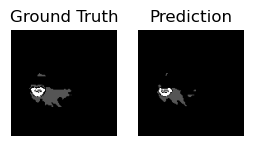

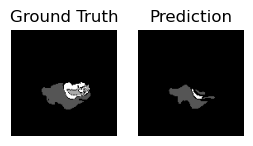

Testing Time: 0.728720239798228 | Testing Loss: 0.0005111135542392731 | Testing Accuracy: 0.9837007646737567 | Testing Jaccard: 0.5581227055145243 | Testing Dice: 0.5807909120152935


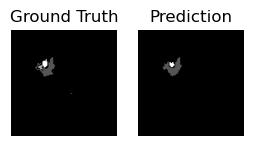

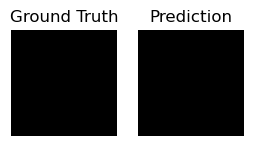

Testing Time: 0.7177080114682516 | Testing Loss: 0.0009232184384018183 | Testing Accuracy: 0.9984716793827901 | Testing Jaccard: 0.42291258666281617 | Testing Dice: 0.4386678293679576


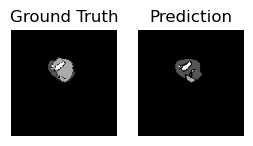

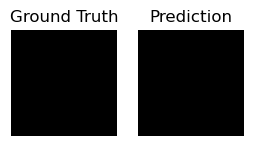

Testing Time: 0.7320386211077372 | Testing Loss: 0.0006098125595599413 | Testing Accuracy: 0.9914713538640939 | Testing Jaccard: 0.576221966473642 | Testing Dice: 0.4950191724249792


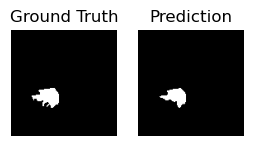

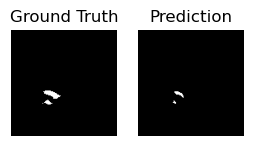

Testing Time: 0.7182544191678365 | Testing Loss: 0.0004933379241265357 | Testing Accuracy: 0.9911519365464826 | Testing Jaccard: 0.5138978919191687 | Testing Dice: 0.46940753280403724


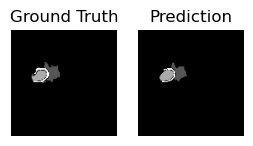

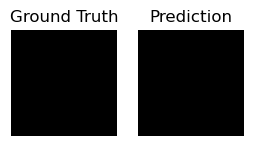

Testing Time: 0.7336883982022603 | Testing Loss: 0.0010282676666975021 | Testing Accuracy: 0.9962101233938978 | Testing Jaccard: 0.7296240115010716 | Testing Dice: 0.6206344839768706


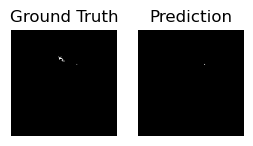

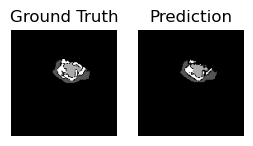

Testing Time: 0.705180271466573 | Testing Loss: 0.0005657398723997176 | Testing Accuracy: 0.9927526852439104 | Testing Jaccard: 0.6592048865195481 | Testing Dice: 0.5090242112074898


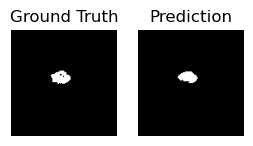

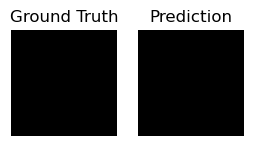

Testing Time: 0.7418365001678466 | Testing Loss: 0.00886599812656641 | Testing Accuracy: 0.9967097978729117 | Testing Jaccard: 0.6767728404768112 | Testing Dice: 0.6926078074284145


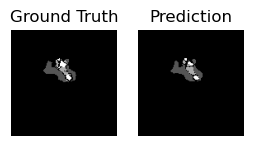

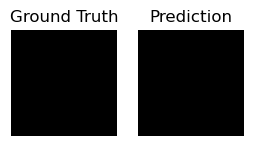

Testing Time: 0.7222339669863383 | Testing Loss: 0.0032608131878077984 | Testing Accuracy: 0.9943066403215614 | Testing Jaccard: 0.5562102259744282 | Testing Dice: 0.5635960907692013


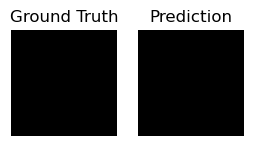

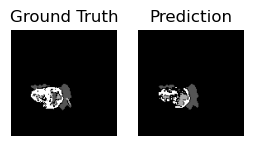

Testing Time: 0.744997215270996 | Testing Loss: 0.001847564708441496 | Testing Accuracy: 0.9908683265205275 | Testing Jaccard: 0.6295947279714553 | Testing Dice: 0.4765733490481924


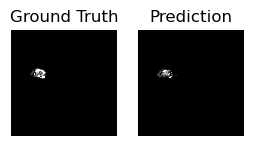

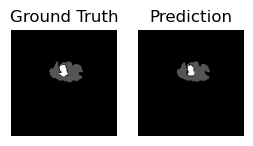

Testing Time: 0.7406899174054463 | Testing Loss: 0.0005492043565027416 | Testing Accuracy: 0.9963484697480218 | Testing Jaccard: 0.6972488385286768 | Testing Dice: 0.5672175945077678


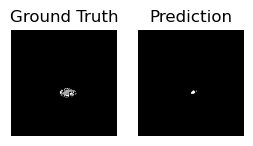

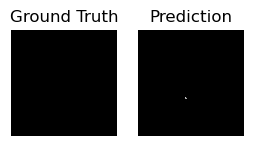

Testing Time: 0.7419676860173543 | Testing Loss: 0.0027180793695151806 | Testing Accuracy: 0.9961568193574554 | Testing Jaccard: 0.48117645806066905 | Testing Dice: 0.32969067030340793


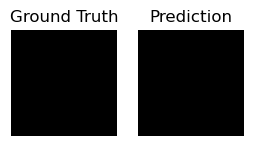

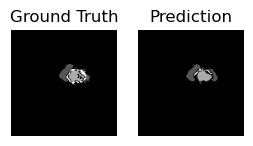

Testing Time: 0.7229835828145345 | Testing Loss: 0.004025560338050127 | Testing Accuracy: 0.9951155595921479 | Testing Jaccard: 0.6328303936402305 | Testing Dice: 0.6008569618283071


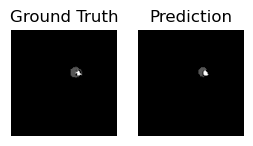

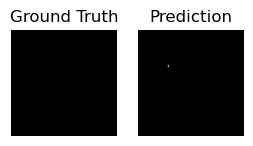

Testing Time: 0.7314698696136475 | Testing Loss: 0.0021044460590928793 | Testing Accuracy: 0.9970690914925927 | Testing Jaccard: 0.34368770588718417 | Testing Dice: 0.23668144201444985


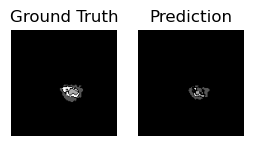

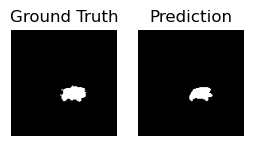

Testing Time: 0.7381288488705953 | Testing Loss: 0.0019150777952745557 | Testing Accuracy: 0.9924165849835962 | Testing Jaccard: 0.443182443740556 | Testing Dice: 0.41976152537790967


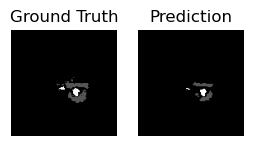

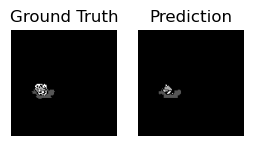

Testing Time: 0.7212029457092285 | Testing Loss: 0.0006548246601596475 | Testing Accuracy: 0.9920788571191164 | Testing Jaccard: 0.2915882909673632 | Testing Dice: 0.3493133418945887


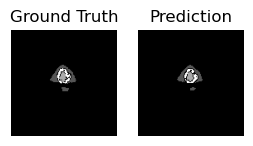

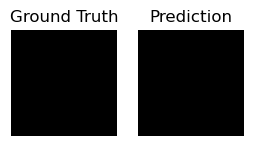

Testing Time: 0.7190130551656088 | Testing Loss: 0.0011829531285911798 | Testing Accuracy: 0.9966434730031402 | Testing Jaccard: 0.5543958467822838 | Testing Dice: 0.4654013446248507


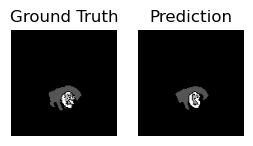

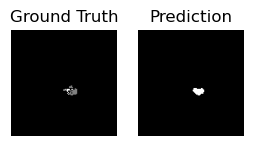

Testing Time: 0.7162224531173706 | Testing Loss: 0.002864199923351407 | Testing Accuracy: 0.9955407711805598 | Testing Jaccard: 0.6432347069215211 | Testing Dice: 0.6099432208280458


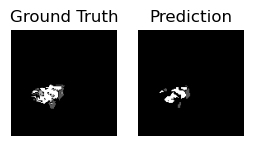

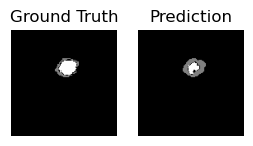

Testing Time: 0.7254049380620321 | Testing Loss: 0.007296475116163492 | Testing Accuracy: 0.9897351071198316 | Testing Jaccard: 0.4708227058049488 | Testing Dice: 0.3309827580283322


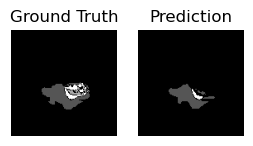

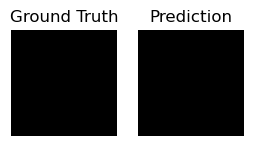

Testing Time: 0.727686083316803 | Testing Loss: 0.0004605057183653116 | Testing Accuracy: 0.990913492536139 | Testing Jaccard: 0.6020552440678151 | Testing Dice: 0.6194379362948986


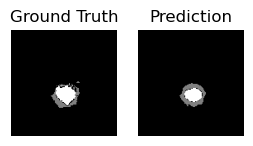

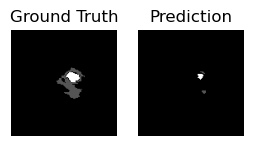

Testing Time: 0.7076175332069397 | Testing Loss: 0.0005023420671932399 | Testing Accuracy: 0.9761832679312589 | Testing Jaccard: 0.3161442607525816 | Testing Dice: 0.2944330192136875


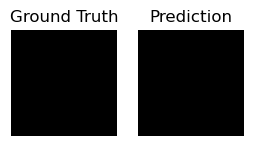

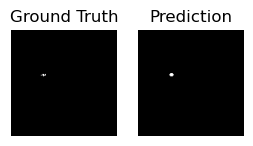

Testing Time: 0.7184065143267314 | Testing Loss: 0.0007003009086474776 | Testing Accuracy: 0.9970735674040495 | Testing Jaccard: 0.34175448112157464 | Testing Dice: 0.30274107156334235


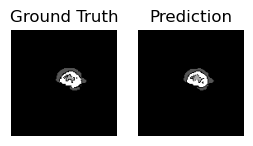

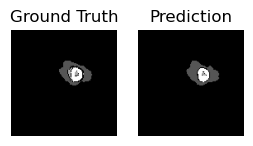

Testing Time: 0.7343422253926595 | Testing Loss: 0.0004427256644703448 | Testing Accuracy: 0.993875732118568 | Testing Jaccard: 0.7295032261056268 | Testing Dice: 0.5535910272555778


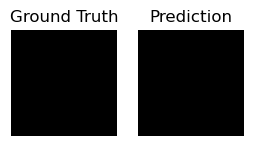

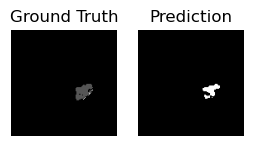

Testing Time: 0.7262465556462606 | Testing Loss: 0.0004660846316255629 | Testing Accuracy: 0.995679931336767 | Testing Jaccard: 0.3819038642997696 | Testing Dice: 0.32438161668406307


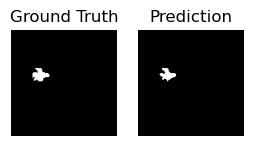

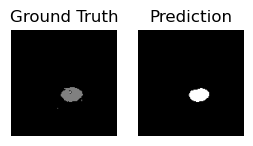

Testing Time: 0.7266650001207987 | Testing Loss: 0.0009404732845723629 | Testing Accuracy: 0.9924763994367032 | Testing Jaccard: 0.5081970670428066 | Testing Dice: 0.4975787033184951


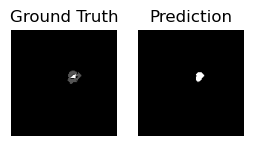

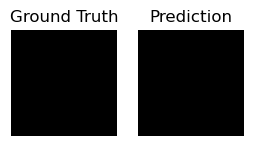

Testing Time: 0.7306576291720073 | Testing Loss: 0.0006881415611132979 | Testing Accuracy: 0.987380777693466 | Testing Jaccard: 0.25794547775756826 | Testing Dice: 0.21324650788655244


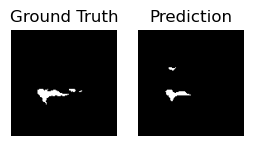

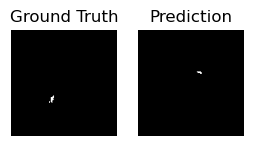

Testing Time: 0.7467211763064067 | Testing Loss: 0.0005817744531668723 | Testing Accuracy: 0.9859635413657738 | Testing Jaccard: 0.4020128735428297 | Testing Dice: 0.40762215582551964


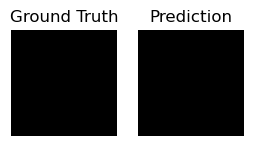

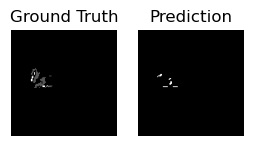

Testing Time: 0.7366633971532186 | Testing Loss: 0.0033130128867924213 | Testing Accuracy: 0.9912007646714678 | Testing Jaccard: 0.33064704802704287 | Testing Dice: 0.3031908300192781


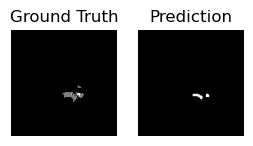

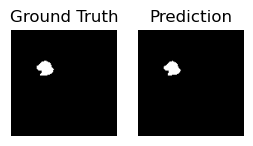

Testing Time: 0.7407017072041829 | Testing Loss: 0.0007941034273244441 | Testing Accuracy: 0.9930480954000708 | Testing Jaccard: 0.552258339567117 | Testing Dice: 0.5044327816679238


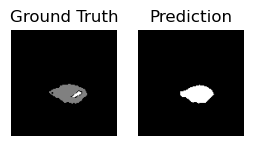

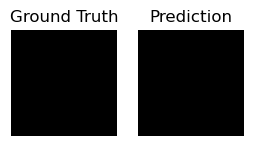

Testing Time: 0.7298417806625366 | Testing Loss: 0.0008488009916618466 | Testing Accuracy: 0.9926802568585157 | Testing Jaccard: 0.519316370293938 | Testing Dice: 0.5168082872566762


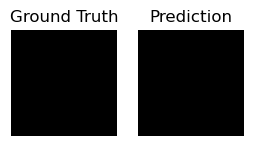

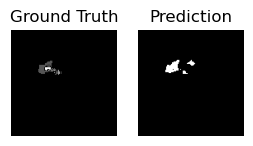

Testing Time: 0.743068810304006 | Testing Loss: 0.017538970336318016 | Testing Accuracy: 0.9930684404521478 | Testing Jaccard: 0.3609733909404277 | Testing Dice: 0.40362618104665254


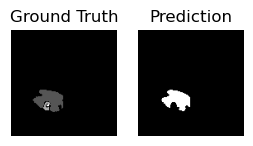

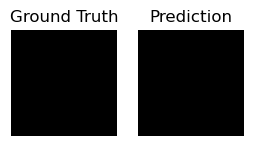

Testing Time: 0.7487561583518982 | Testing Loss: 0.0006670214352197945 | Testing Accuracy: 0.9958756507377488 | Testing Jaccard: 0.6226816522531047 | Testing Dice: 0.6405854942544508


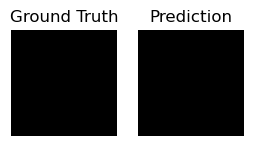

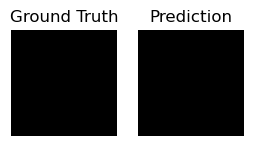

Testing Time: 0.7519792358080546 | Testing Loss: 0.00046062422916293144 | Testing Accuracy: 0.99355468719679 | Testing Jaccard: 0.25313186795121195 | Testing Dice: 0.2506287502265025


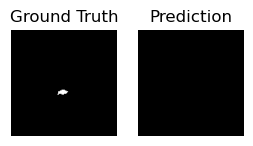

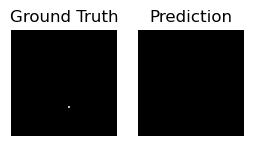

Testing Time: 0.7423040390014648 | Testing Loss: 0.0008505684672854841 | Testing Accuracy: 0.9983369951380388 | Testing Jaccard: 0.06014629670021588 | Testing Dice: 0.0900562367522498


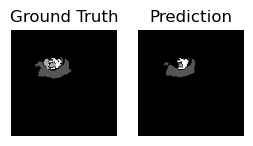

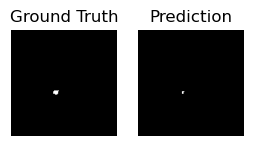

Testing Time: 0.7877374053001404 | Testing Loss: 0.0007793186232447624 | Testing Accuracy: 0.9922379554263597 | Testing Jaccard: 0.5433122753628506 | Testing Dice: 0.5564649908348527


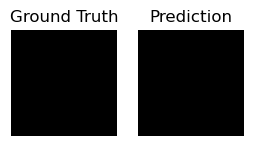

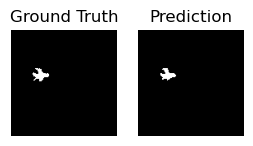

Testing Time: 0.7519558032353719 | Testing Loss: 0.0004453598812688142 | Testing Accuracy: 0.9966581214406354 | Testing Jaccard: 0.5907383448015547 | Testing Dice: 0.5677075391218046


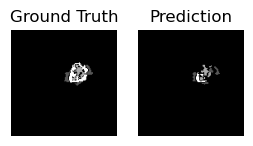

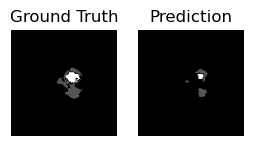

Testing Time: 0.7618190089861552 | Testing Loss: 0.0012447796761989594 | Testing Accuracy: 0.9827030433198941 | Testing Jaccard: 0.33473455905781063 | Testing Dice: 0.2650116878323995


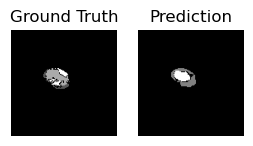

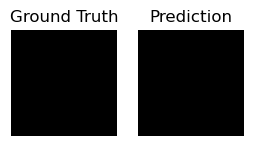

Testing Time: 0.7387975931167603 | Testing Loss: 0.0010795901762321591 | Testing Accuracy: 0.9925838213116707 | Testing Jaccard: 0.46945064528094754 | Testing Dice: 0.36364277013142843


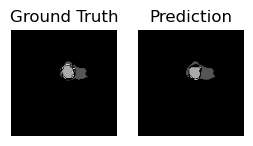

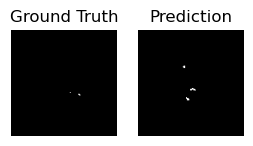

Testing Time: 0.7513121604919434 | Testing Loss: 0.0004708686319645494 | Testing Accuracy: 0.9925732418845902 | Testing Jaccard: 0.5733873125047356 | Testing Dice: 0.4648633523496889


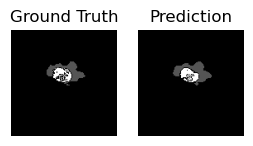

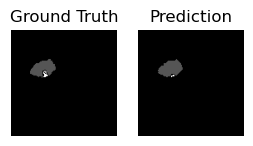

Testing Time: 0.7402498722076416 | Testing Loss: 0.005172482691705227 | Testing Accuracy: 0.993243814801053 | Testing Jaccard: 0.7409686564856848 | Testing Dice: 0.535457166004122


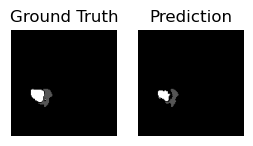

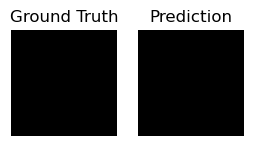

Testing Time: 0.7360981225967407 | Testing Loss: 0.00044136118958704174 | Testing Accuracy: 0.9944364417538132 | Testing Jaccard: 0.3689186687585613 | Testing Dice: 0.27402397799485945


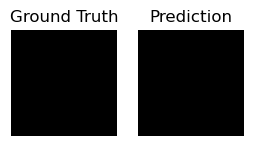

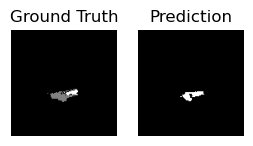

Testing Time: 0.7419960379600525 | Testing Loss: 0.0004955511540174484 | Testing Accuracy: 0.9897045895417151 | Testing Jaccard: 0.3029251772489944 | Testing Dice: 0.3728377747134262


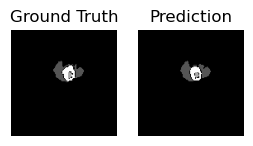

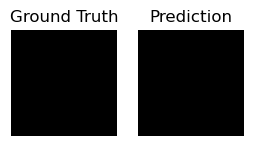

Testing Time: 0.7573424657185872 | Testing Loss: 0.00047078245552256703 | Testing Accuracy: 0.9972932939664833 | Testing Jaccard: 0.724295017935328 | Testing Dice: 0.5822698485653132


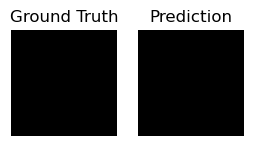

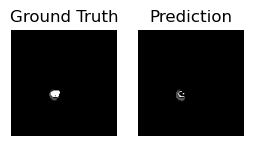

Testing Time: 0.7405050357182821 | Testing Loss: 0.0023808996193110943 | Testing Accuracy: 0.993222655946892 | Testing Jaccard: 0.2549052265138771 | Testing Dice: 0.22727841116975583


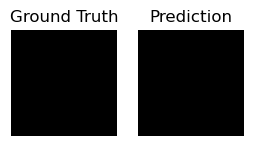

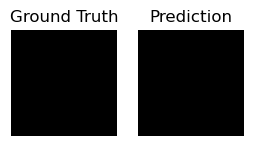

Testing Time: 0.7415046334266663 | Testing Loss: 0.00043992072460241616 | Testing Accuracy: 0.9966564938364689 | Testing Jaccard: 0.23239617351956998 | Testing Dice: 0.24392092167888407


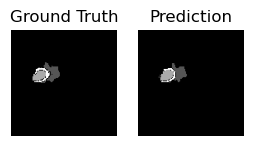

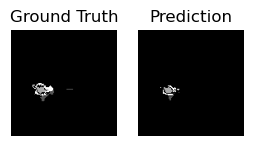

Testing Time: 0.7406391501426697 | Testing Loss: 0.002661787671968341 | Testing Accuracy: 0.9951859534723351 | Testing Jaccard: 0.7107231802405213 | Testing Dice: 0.5701028100271402


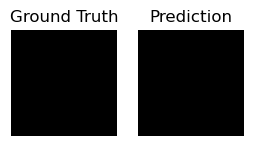

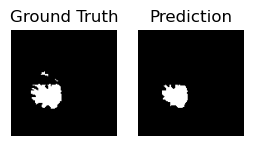

Testing Time: 0.7352780222892761 | Testing Loss: 0.0017388500273227692 | Testing Accuracy: 0.9941377763893212 | Testing Jaccard: 0.6705402702399058 | Testing Dice: 0.6786541755970354


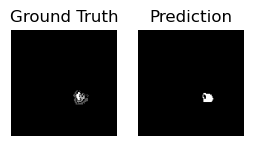

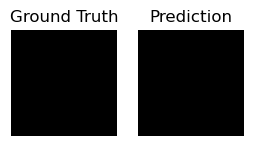

Testing Time: 0.7432536800702413 | Testing Loss: 0.0010588227305561304 | Testing Accuracy: 0.9961718746959918 | Testing Jaccard: 0.34992426764388007 | Testing Dice: 0.34260442314968353


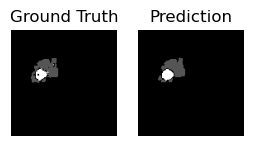

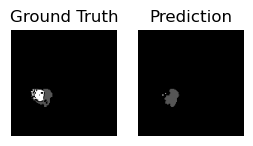

Testing Time: 0.7352752248446147 | Testing Loss: 0.00048001849791035056 | Testing Accuracy: 0.9924300127179674 | Testing Jaccard: 0.7357431017529272 | Testing Dice: 0.6436095556774803


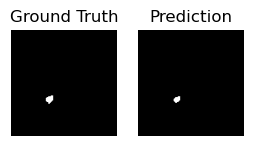

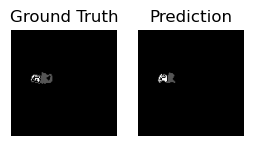

Testing Time: 0.7513356526692708 | Testing Loss: 0.00047292900853790343 | Testing Accuracy: 0.9953670244358208 | Testing Jaccard: 0.39198238626594445 | Testing Dice: 0.3292006769254358


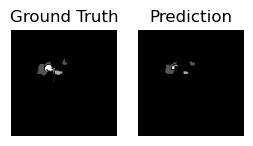

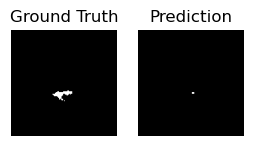

Testing Time: 0.7273543039957683 | Testing Loss: 0.005177545361220837 | Testing Accuracy: 0.991929117535829 | Testing Jaccard: 0.470576289910222 | Testing Dice: 0.48094141449928857


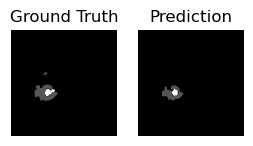

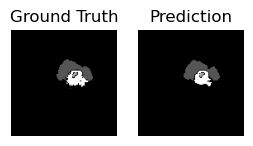

Testing Time: 0.728865385055542 | Testing Loss: 0.0005798733327537775 | Testing Accuracy: 0.9898238115468878 | Testing Jaccard: 0.6305560165476177 | Testing Dice: 0.5431764020810768


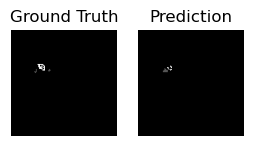

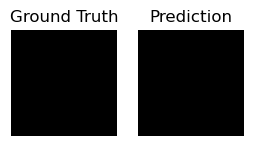

Testing Time: 0.7361951907475789 | Testing Loss: 0.002237089676782489 | Testing Accuracy: 0.9972863766487768 | Testing Jaccard: 0.3338260588949317 | Testing Dice: 0.2623182609763337


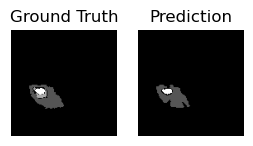

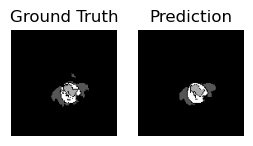

Testing Time: 0.7751846512158712 | Testing Loss: 0.0018379599787294865 | Testing Accuracy: 0.9916361487859179 | Testing Jaccard: 0.6383759601692086 | Testing Dice: 0.6038410005713135


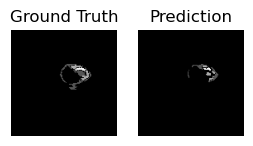

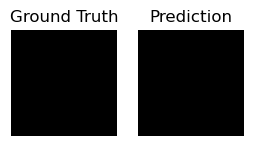

Testing Time: 0.7306678771972657 | Testing Loss: 0.0008176052360795438 | Testing Accuracy: 0.9925581865460532 | Testing Jaccard: 0.48089410229627105 | Testing Dice: 0.4997589431639068


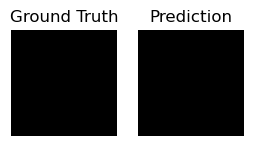

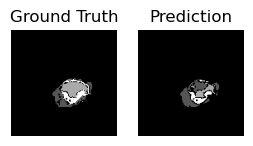

Testing Time: 0.7636587103207906 | Testing Loss: 0.000536278123036027 | Testing Accuracy: 0.9920353187076713 | Testing Jaccard: 0.5295453700231736 | Testing Dice: 0.39845678120219946


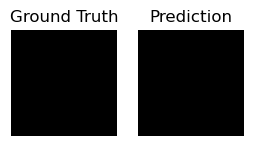

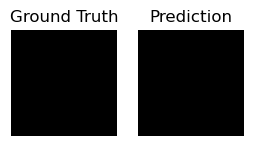

Testing Time: 0.7365890741348267 | Testing Loss: 0.0009109606617130339 | Testing Accuracy: 0.9957718909721549 | Testing Jaccard: 0.1723314474643645 | Testing Dice: 0.19885377961033218


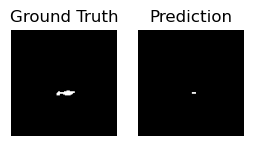

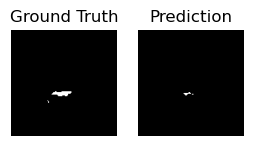

Testing Time: 0.7403310775756836 | Testing Loss: 0.00046098363236524165 | Testing Accuracy: 0.9895772295157124 | Testing Jaccard: 0.13802449147906776 | Testing Dice: 0.17154797386076764


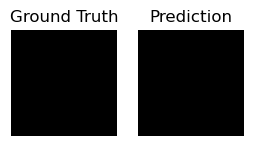

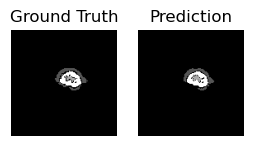

Testing Time: 0.730238695939382 | Testing Loss: 0.0007647632155567408 | Testing Accuracy: 0.9958569332898384 | Testing Jaccard: 0.6726069718216799 | Testing Dice: 0.5193539425987843


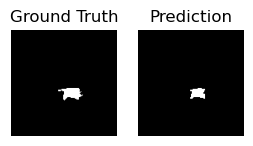

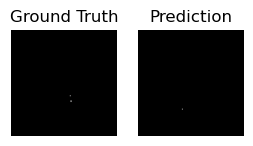

Testing Time: 0.7458527485529581 | Testing Loss: 0.0006783052231185138 | Testing Accuracy: 0.9928413896709666 | Testing Jaccard: 0.3557759866017707 | Testing Dice: 0.41606489013392617


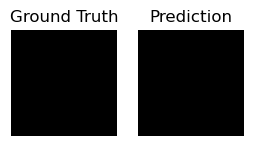

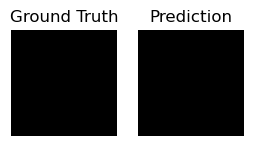

Testing Time: 0.7389553944269817 | Testing Loss: 0.00048234459245577455 | Testing Accuracy: 0.9970967607634176 | Testing Jaccard: 0.21489599125681508 | Testing Dice: 0.2401588635333864


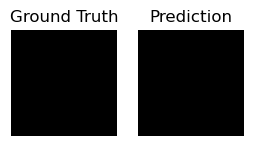

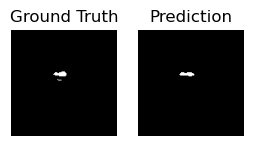

Testing Time: 0.7424363374710083 | Testing Loss: 0.0005420664674602449 | Testing Accuracy: 0.9950968421442362 | Testing Jaccard: 0.3796886236563999 | Testing Dice: 0.32128949858169165


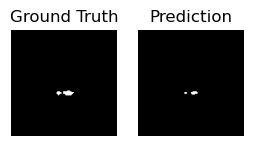

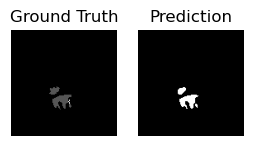

Testing Time: 0.727241309483846 | Testing Loss: 0.0007750415243208408 | Testing Accuracy: 0.996890461935356 | Testing Jaccard: 0.6186551283225232 | Testing Dice: 0.6545554546131417


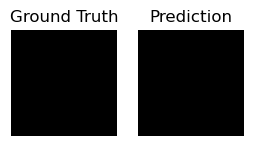

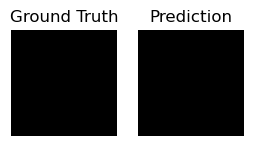

Testing Time: 0.7419692873954773 | Testing Loss: 0.0005179881118237972 | Testing Accuracy: 0.9987272132368781 | Testing Jaccard: 0.3606856605157254 | Testing Dice: 0.3639448950745431


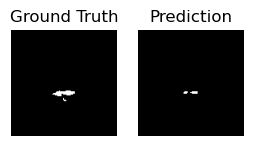

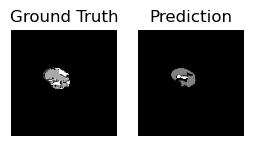

Testing Time: 0.7213460723559062 | Testing Loss: 0.0005341698997654021 | Testing Accuracy: 0.9872395830320513 | Testing Jaccard: 0.3858792220577025 | Testing Dice: 0.3609728431993962


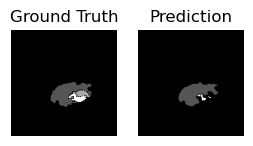

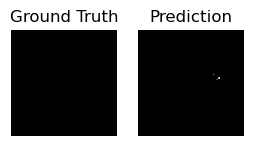

Testing Time: 0.7199743310610454 | Testing Loss: 0.0008871965692378581 | Testing Accuracy: 0.9909240719632187 | Testing Jaccard: 0.5803275175730053 | Testing Dice: 0.5363497294770755


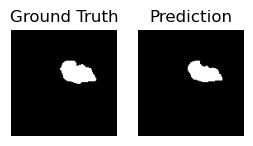

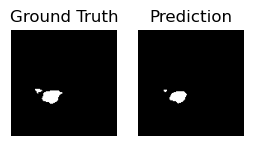

Testing Time: 0.7307735006014506 | Testing Loss: 0.0012185705127194524 | Testing Accuracy: 0.9837154131112518 | Testing Jaccard: 0.49853855904730904 | Testing Dice: 0.5100091240592503


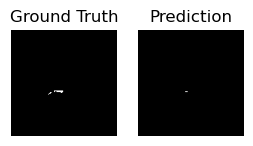

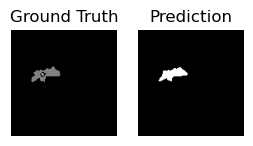

Testing Time: 0.7286211927731832 | Testing Loss: 0.0006954955169931054 | Testing Accuracy: 0.9928597002178369 | Testing Jaccard: 0.6484057263267992 | Testing Dice: 0.6697658882428303


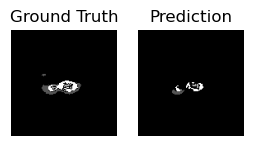

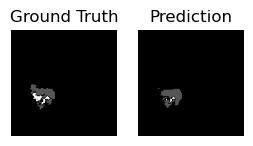

Testing Time: 0.7297830899556478 | Testing Loss: 0.0005617245915345848 | Testing Accuracy: 0.9910758460517144 | Testing Jaccard: 0.4859380472807032 | Testing Dice: 0.42292704673459286


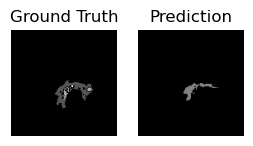

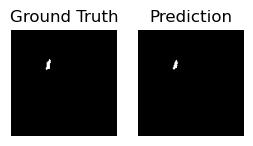

Testing Time: 0.7494957009951274 | Testing Loss: 0.0004930353024974465 | Testing Accuracy: 0.9910062659736102 | Testing Jaccard: 0.34984749756393285 | Testing Dice: 0.45062244529554213


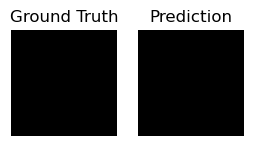

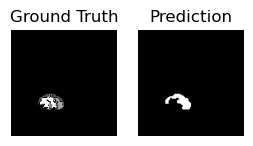

Testing Time: 0.7217628002166748 | Testing Loss: 0.011279202997684479 | Testing Accuracy: 0.9948221839411957 | Testing Jaccard: 0.5137989568936239 | Testing Dice: 0.4980057274523938


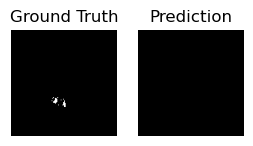

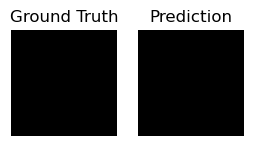

Testing Time: 0.7249705553054809 | Testing Loss: 0.0005939386901445687 | Testing Accuracy: 0.9951871741754585 | Testing Jaccard: 0.3513586794316905 | Testing Dice: 0.2505079219285871


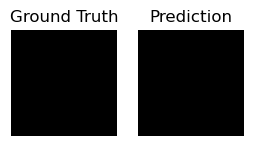

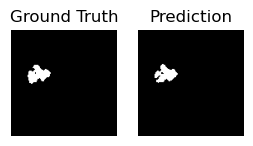

Testing Time: 0.729879601796468 | Testing Loss: 0.0004941743100062013 | Testing Accuracy: 0.9977950029507048 | Testing Jaccard: 0.6545316464727784 | Testing Dice: 0.6787555075084745


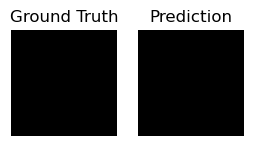

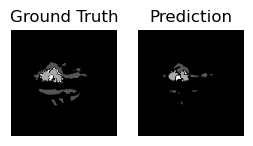

Testing Time: 0.7373277425765992 | Testing Loss: 0.00047812453703954816 | Testing Accuracy: 0.990142008161374 | Testing Jaccard: 0.5082587354548248 | Testing Dice: 0.5499530993026184


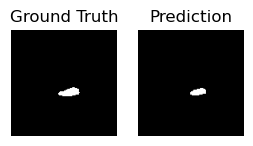

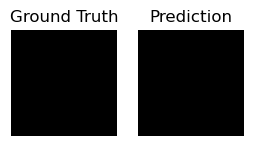

Testing Time: 0.7272771437962849 | Testing Loss: 0.0005832622991874814 | Testing Accuracy: 0.9936637366759239 | Testing Jaccard: 0.3813555702684415 | Testing Dice: 0.38991732790969996


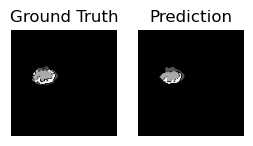

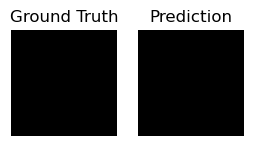

Testing Time: 0.7437170743942261 | Testing Loss: 0.001097886124625802 | Testing Accuracy: 0.9962117509980634 | Testing Jaccard: 0.5503966937768628 | Testing Dice: 0.41861859287927056


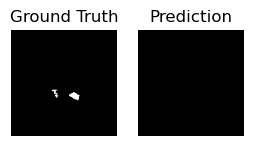

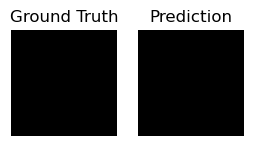

Testing Time: 0.7220241109530131 | Testing Loss: 0.0007345638005062938 | Testing Accuracy: 0.9916015621973862 | Testing Jaccard: 0.3461537055499354 | Testing Dice: 0.3696268976305692


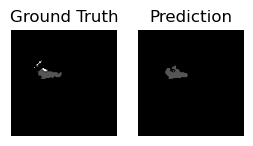

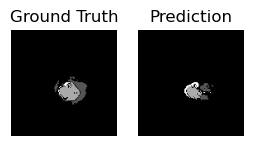

Testing Time: 0.709644599755605 | Testing Loss: 0.00140932307112962 | Testing Accuracy: 0.9877852373287599 | Testing Jaccard: 0.4284752835234072 | Testing Dice: 0.3516935558773569


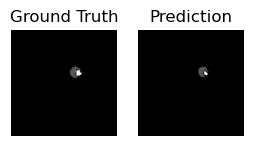

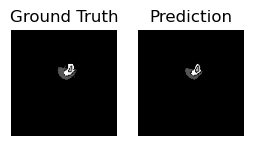

Testing Time: 0.724224591255188 | Testing Loss: 0.0014167276676744223 | Testing Accuracy: 0.9969502763884628 | Testing Jaccard: 0.41814909227384084 | Testing Dice: 0.3270345883708736


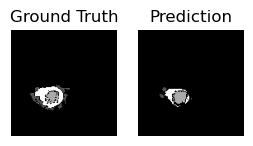

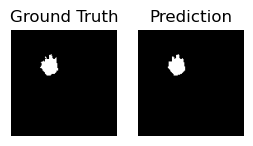

Testing Time: 0.7183905482292176 | Testing Loss: 0.0005931015475653112 | Testing Accuracy: 0.9889644365471503 | Testing Jaccard: 0.3765570929313615 | Testing Dice: 0.28351285739552795


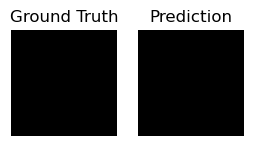

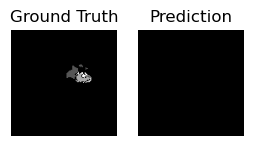

Testing Time: 0.733387025197347 | Testing Loss: 0.0014102181885391474 | Testing Accuracy: 0.9812988278255312 | Testing Jaccard: 0.22814574590935682 | Testing Dice: 0.21013412486164038


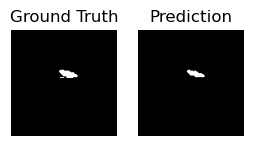

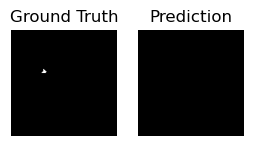

Testing Time: 0.7161126534144083 | Testing Loss: 0.0005195302655920386 | Testing Accuracy: 0.9944018551652816 | Testing Jaccard: 0.35148875192724666 | Testing Dice: 0.2914169148493224


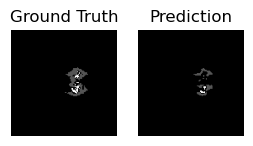

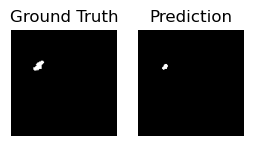

Testing Time: 0.7056419372558593 | Testing Loss: 0.0009667105041444302 | Testing Accuracy: 0.9930444332906965 | Testing Jaccard: 0.46399771812192037 | Testing Dice: 0.4587966634491169


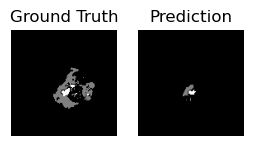

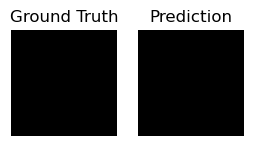

Testing Time: 0.7119932810465495 | Testing Loss: 0.0005130477366037667 | Testing Accuracy: 0.9816381832941776 | Testing Jaccard: 0.15751659890787745 | Testing Dice: 0.22347642237864748


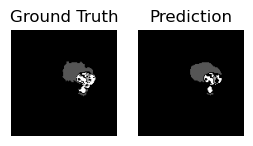

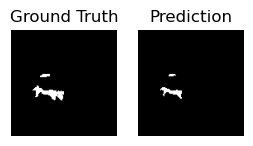

Testing Time: 0.726179575920105 | Testing Loss: 0.005495931953191757 | Testing Accuracy: 0.9902445472238426 | Testing Jaccard: 0.6357877367092462 | Testing Dice: 0.595746098015994


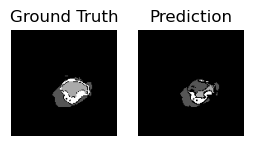

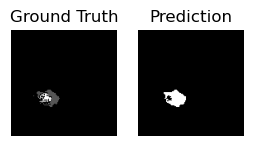

Testing Time: 0.7145966370900472 | Testing Loss: 0.00042174040572717786 | Testing Accuracy: 0.9877958167558402 | Testing Jaccard: 0.5858658523168923 | Testing Dice: 0.46240661692442037


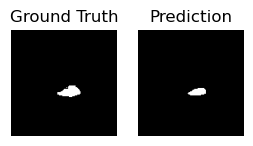

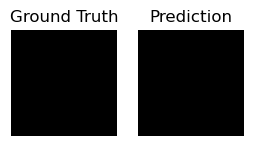

Testing Time: 0.7119448026021321 | Testing Loss: 0.0007486642571166158 | Testing Accuracy: 0.990339762067563 | Testing Jaccard: 0.3843268129497996 | Testing Dice: 0.3647368850583459


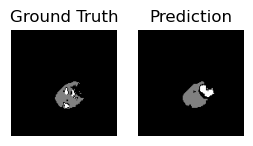

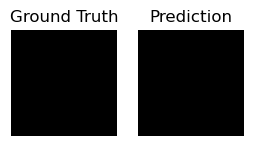

Testing Time: 0.7411121884981792 | Testing Loss: 0.000505029980558902 | Testing Accuracy: 0.9888191728753194 | Testing Jaccard: 0.44577153883161447 | Testing Dice: 0.47438720884941676


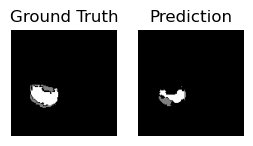

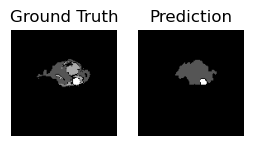

Testing Time: 0.735777759552002 | Testing Loss: 0.002452953951433301 | Testing Accuracy: 0.9804252112893397 | Testing Jaccard: 0.5428434317311416 | Testing Dice: 0.532675958207739


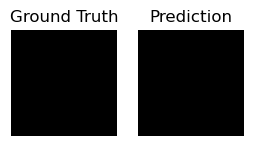

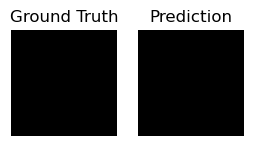

Testing Time: 0.7356038848559062 | Testing Loss: 0.0011824264656752348 | Testing Accuracy: 0.9991113278200944 | Testing Jaccard: 0.010407526956119816 | Testing Dice: 0.009406796157684057


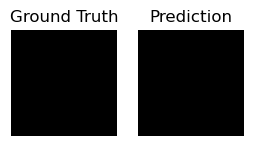

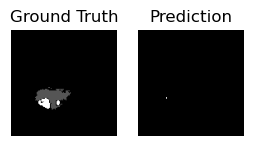

Testing Time: 0.7406676332155864 | Testing Loss: 0.0007499273051507771 | Testing Accuracy: 0.985662027693991 | Testing Jaccard: 0.1640539698484405 | Testing Dice: 0.17823458868821002


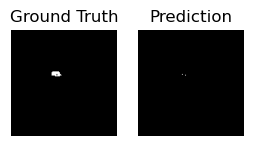

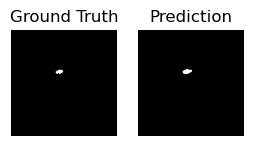

Testing Time: 0.7332911928494771 | Testing Loss: 0.00778707442805171 | Testing Accuracy: 0.9970056149301129 | Testing Jaccard: 0.575299481278429 | Testing Dice: 0.5074121187848316


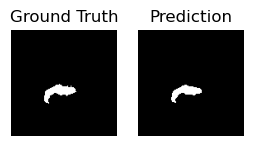

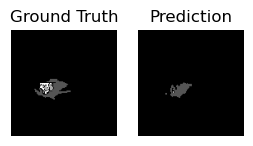

Testing Time: 0.7525162021319072 | Testing Loss: 0.0005342034855857491 | Testing Accuracy: 0.9892321774324849 | Testing Jaccard: 0.44705672955742226 | Testing Dice: 0.48215299351643087


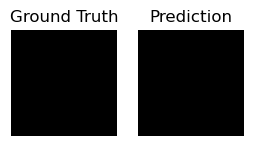

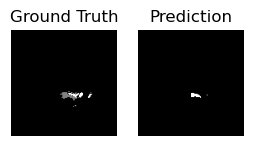

Testing Time: 0.7163267572720845 | Testing Loss: 0.0009440327994525433 | Testing Accuracy: 0.997255045268578 | Testing Jaccard: 0.39696485884378524 | Testing Dice: 0.40216537760031545


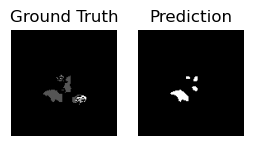

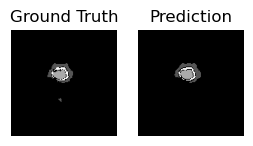

Testing Time: 0.7215443094571431 | Testing Loss: 0.001047672936692834 | Testing Accuracy: 0.9939204912331376 | Testing Jaccard: 0.581325487081061 | Testing Dice: 0.5195192973633431


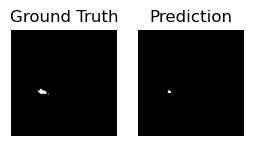

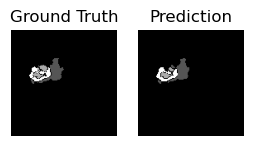

Testing Time: 0.7383157889048259 | Testing Loss: 0.0009636240429244936 | Testing Accuracy: 0.9945255530819113 | Testing Jaccard: 0.6466434416758293 | Testing Dice: 0.5436507329036945


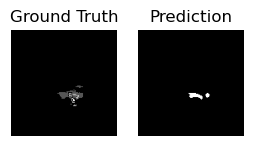

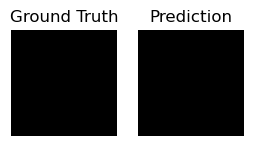

Testing Time: 0.728596047560374 | Testing Loss: 0.0004987689899280667 | Testing Accuracy: 0.9950065101130144 | Testing Jaccard: 0.4285011926747396 | Testing Dice: 0.5138703404077942


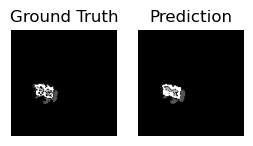

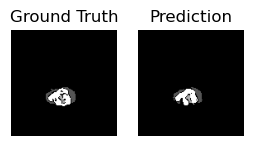

Testing Time: 0.75657666126887 | Testing Loss: 0.0005147280753590167 | Testing Accuracy: 0.9932556149312578 | Testing Jaccard: 0.5504418381930248 | Testing Dice: 0.3973646477432363


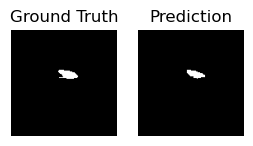

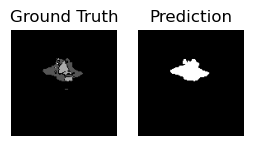

Testing Time: 0.7279777566591898 | Testing Loss: 0.0004771162639372051 | Testing Accuracy: 0.992182209983668 | Testing Jaccard: 0.6896450186358974 | Testing Dice: 0.660798947654361


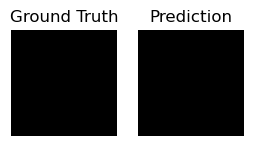

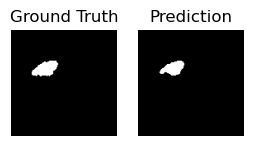

Testing Time: 0.7331627368927002 | Testing Loss: 0.0006474299007095397 | Testing Accuracy: 0.9921154782128546 | Testing Jaccard: 0.46140913005798223 | Testing Dice: 0.47439484689553796


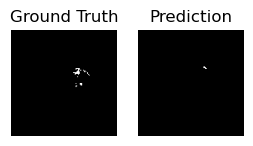

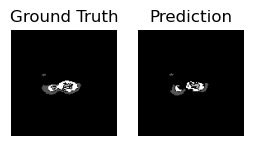

Testing Time: 0.7160374005635579 | Testing Loss: 0.0011892239563167095 | Testing Accuracy: 0.9947762041235014 | Testing Jaccard: 0.4147275816668005 | Testing Dice: 0.4013662159709119


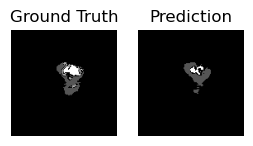

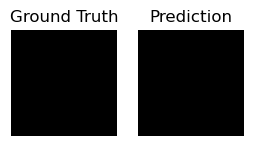

Testing Time: 0.7260504245758057 | Testing Loss: 0.0008614702965132892 | Testing Accuracy: 0.9908333330309548 | Testing Jaccard: 0.44299033710538616 | Testing Dice: 0.4546116529925126


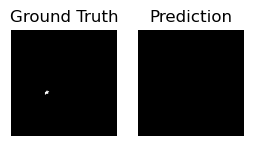

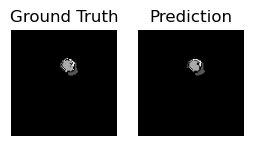

Testing Time: 0.7121713916460674 | Testing Loss: 0.0004345466149970889 | Testing Accuracy: 0.9959533688366834 | Testing Jaccard: 0.4210839772434566 | Testing Dice: 0.3917574857507229


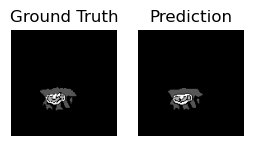

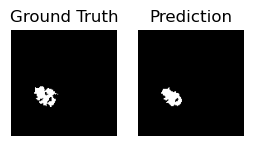

Testing Time: 0.7238966345787048 | Testing Loss: 0.0011169890640303493 | Testing Accuracy: 0.9944584144100573 | Testing Jaccard: 0.7424040005071003 | Testing Dice: 0.7770271993722185


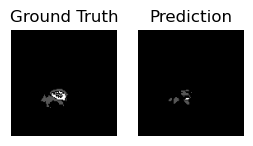

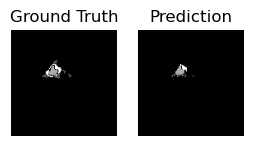

Testing Time: 0.7176340063412984 | Testing Loss: 0.0004903428489342332 | Testing Accuracy: 0.9942545569882438 | Testing Jaccard: 0.461835977075002 | Testing Dice: 0.4151350279124077


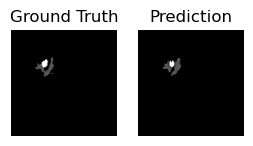

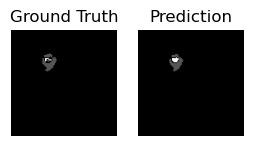

Testing Time: 0.7215387185414632 | Testing Loss: 0.0005237380391918123 | Testing Accuracy: 0.9978820797735949 | Testing Jaccard: 0.5054293020910724 | Testing Dice: 0.463045457939213


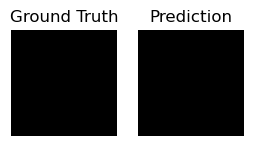

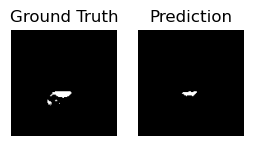

Testing Time: 0.7168410897254944 | Testing Loss: 0.0004323103348724544 | Testing Accuracy: 0.9903210446196522 | Testing Jaccard: 0.26752967207795475 | Testing Dice: 0.30208229474624154


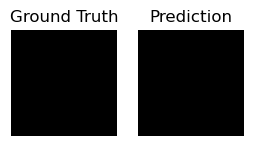

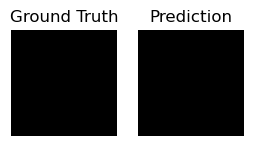

Testing Time: 0.7102238933245341 | Testing Loss: 0.005560687277466059 | Testing Accuracy: 0.9944620765194301 | Testing Jaccard: 0.12218112274494813 | Testing Dice: 0.1221750741002265


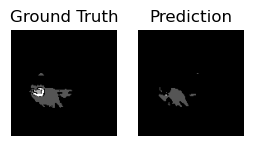

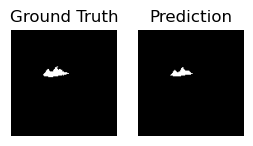

Testing Time: 0.7123825669288635 | Testing Loss: 0.0008577731205150485 | Testing Accuracy: 0.9926123043845786 | Testing Jaccard: 0.5876282922019349 | Testing Dice: 0.6764419343744528


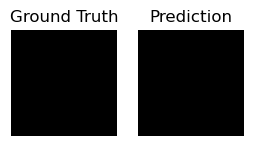

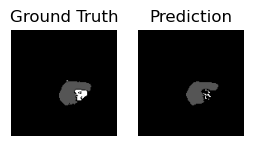

Testing Time: 0.7125383377075195 | Testing Loss: 0.001846047700382769 | Testing Accuracy: 0.9957942705294412 | Testing Jaccard: 0.6039245801058852 | Testing Dice: 0.6553967417947072


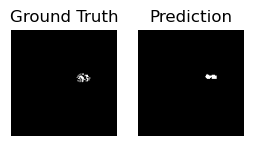

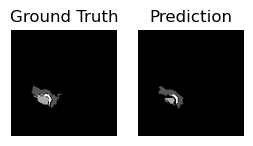

Testing Time: 0.740328828493754 | Testing Loss: 0.00044584611896425486 | Testing Accuracy: 0.9943631995663357 | Testing Jaccard: 0.4933955434894903 | Testing Dice: 0.4507943981238671


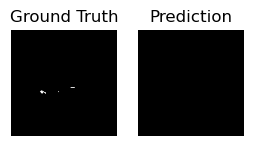

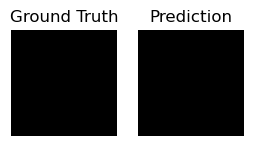

Testing Time: 0.7409385402997335 | Testing Loss: 0.0006061285967007279 | Testing Accuracy: 0.9908951819892686 | Testing Jaccard: 0.2190316782398693 | Testing Dice: 0.24645569993827224


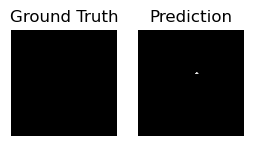

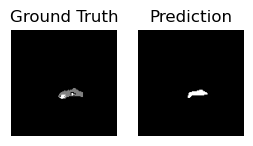

Testing Time: 0.7307601769765218 | Testing Loss: 0.0009484242764301598 | Testing Accuracy: 0.9940641273008016 | Testing Jaccard: 0.326184767059868 | Testing Dice: 0.2508111180903916


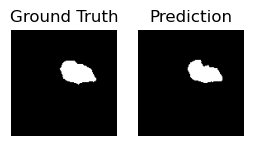

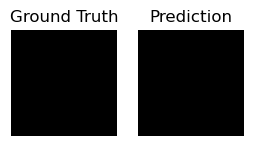

Testing Time: 0.7390789151191711 | Testing Loss: 0.0006979218451306224 | Testing Accuracy: 0.9949910478734356 | Testing Jaccard: 0.6127294781408168 | Testing Dice: 0.5368346712134315


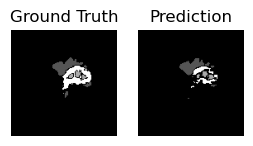

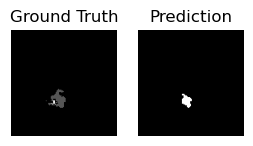

Testing Time: 0.7269064704577128 | Testing Loss: 0.004058838356286287 | Testing Accuracy: 0.9833251950124128 | Testing Jaccard: 0.659952043826802 | Testing Dice: 0.5023036309421414


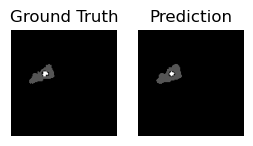

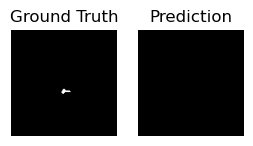

Testing Time: 0.7236099481582642 | Testing Loss: 0.0005383934476412833 | Testing Accuracy: 0.9967256670135318 | Testing Jaccard: 0.583033952104649 | Testing Dice: 0.5935977810964973


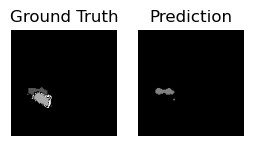

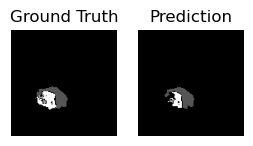

Testing Time: 0.7538790345191956 | Testing Loss: 0.0007286506588570774 | Testing Accuracy: 0.9919266761295796 | Testing Jaccard: 0.6259528608176911 | Testing Dice: 0.5893185657245359


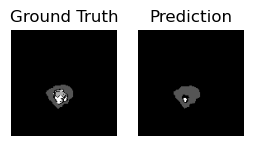

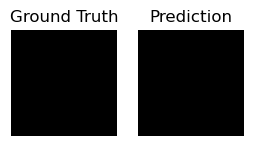

Testing Time: 0.7181902090708415 | Testing Loss: 0.005316192749887705 | Testing Accuracy: 0.9920715329003686 | Testing Jaccard: 0.6208273846000018 | Testing Dice: 0.6200304608201057


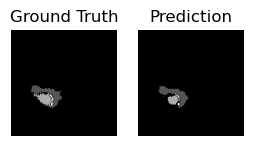

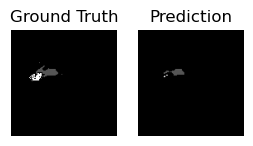

Testing Time: 0.733796254793803 | Testing Loss: 0.00044188511674292386 | Testing Accuracy: 0.9913846839422447 | Testing Jaccard: 0.5011117980698966 | Testing Dice: 0.4795613189797299


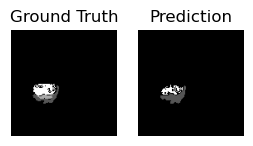

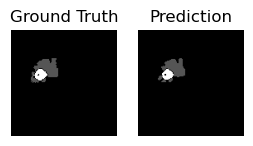

Testing Time: 0.7354048172632853 | Testing Loss: 0.0004381888429634273 | Testing Accuracy: 0.9914298499578562 | Testing Jaccard: 0.6913323302914925 | Testing Dice: 0.6062291031164747


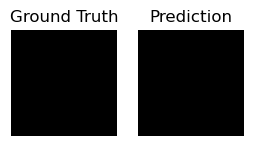

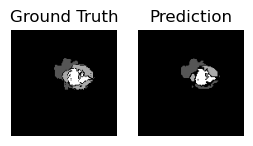

Testing Time: 0.738802146911621 | Testing Loss: 0.003785547334700823 | Testing Accuracy: 0.9915295407130342 | Testing Jaccard: 0.6245430152518292 | Testing Dice: 0.5399478821567245


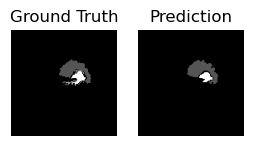

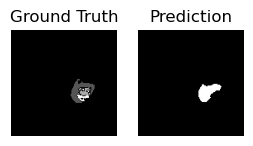

Testing Time: 0.7203680475552877 | Testing Loss: 0.0019367020577192307 | Testing Accuracy: 0.9903340654529823 | Testing Jaccard: 0.7176933308894652 | Testing Dice: 0.6593140580933614


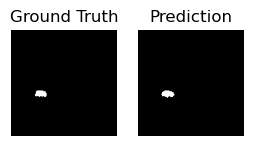

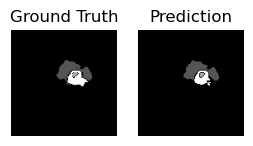

Testing Time: 0.7373217741648356 | Testing Loss: 0.0004709659842774272 | Testing Accuracy: 0.9956079098524143 | Testing Jaccard: 0.724127292423367 | Testing Dice: 0.6040865981323799


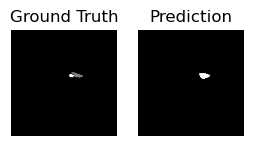

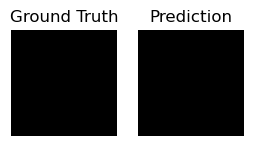

Testing Time: 0.7270755688349406 | Testing Loss: 0.006237842608243227 | Testing Accuracy: 0.997681477560115 | Testing Jaccard: 0.6044898403231574 | Testing Dice: 0.6405018064707355


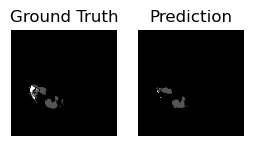

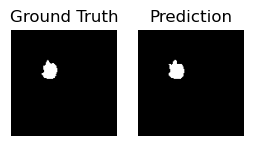

Testing Time: 0.7378113587697347 | Testing Loss: 0.0027456770185381174 | Testing Accuracy: 0.995269775086893 | Testing Jaccard: 0.4443425473904258 | Testing Dice: 0.4242196622516953


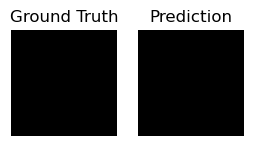

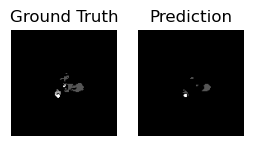

Testing Time: 0.7195725997289022 | Testing Loss: 0.0004695281386375427 | Testing Accuracy: 0.9961018877168468 | Testing Jaccard: 0.5535097713950006 | Testing Dice: 0.5848762640471749


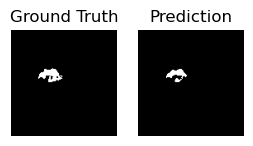

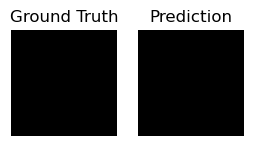

Testing Time: 0.7208205580711364 | Testing Loss: 0.0006525075295940042 | Testing Accuracy: 0.9972957353727323 | Testing Jaccard: 0.3560511008819561 | Testing Dice: 0.3881022129226738


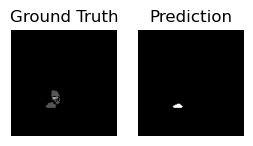

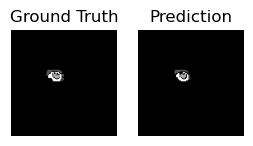

Testing Time: 0.732414448261261 | Testing Loss: 0.0004731925728265196 | Testing Accuracy: 0.9967614743051875 | Testing Jaccard: 0.4540215760113787 | Testing Dice: 0.4529895643460137


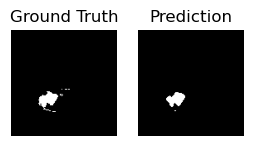

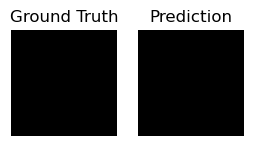

Testing Time: 0.7158766667048136 | Testing Loss: 0.0005644900375045836 | Testing Accuracy: 0.9952054847223284 | Testing Jaccard: 0.46387689351557737 | Testing Dice: 0.5307336827193863


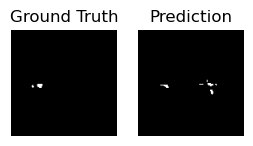

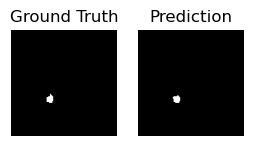

Testing Time: 0.7564703623453776 | Testing Loss: 0.00046221184311434627 | Testing Accuracy: 0.9887337236565952 | Testing Jaccard: 0.3064847799200897 | Testing Dice: 0.27807751599082703


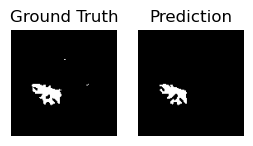

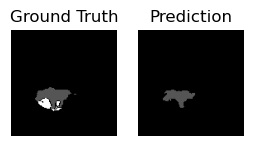

Testing Time: 0.7187112291653951 | Testing Loss: 0.0056895059533417225 | Testing Accuracy: 0.9850626624597995 | Testing Jaccard: 0.4683502313023515 | Testing Dice: 0.49321921515666134


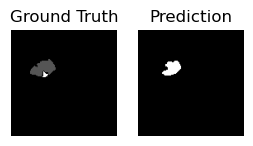

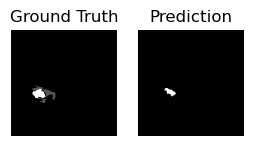

Testing Time: 0.750780721505483 | Testing Loss: 0.00044169186730869114 | Testing Accuracy: 0.9839200843351478 | Testing Jaccard: 0.24304886560168218 | Testing Dice: 0.22421593012697333


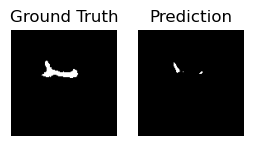

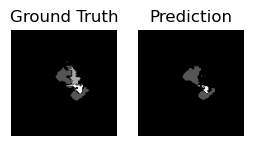

Testing Time: 0.7218764583269756 | Testing Loss: 0.0031202416867017746 | Testing Accuracy: 0.9781660967066955 | Testing Jaccard: 0.3362188427884813 | Testing Dice: 0.3845733079020587


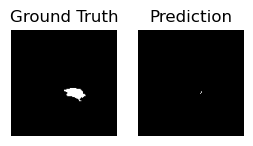

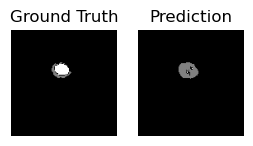

Testing Time: 0.74696337779363 | Testing Loss: 0.005323066841810942 | Testing Accuracy: 0.992725422874127 | Testing Jaccard: 0.36435149023479196 | Testing Dice: 0.32307485739843356


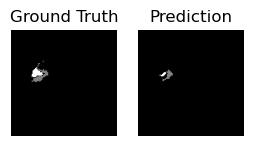

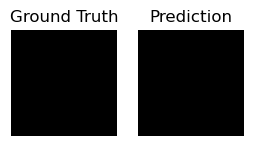

Testing Time: 0.706590207417806 | Testing Loss: 0.0006697450880892575 | Testing Accuracy: 0.9945699052954395 | Testing Jaccard: 0.25641431386425706 | Testing Dice: 0.2792299583101604


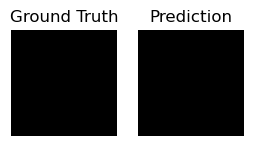

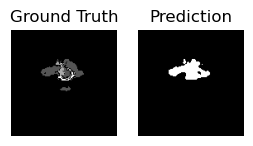

Testing Time: 0.7249632000923156 | Testing Loss: 0.0006999974139034748 | Testing Accuracy: 0.9908467607653262 | Testing Jaccard: 0.6095422797033638 | Testing Dice: 0.6238091719699973


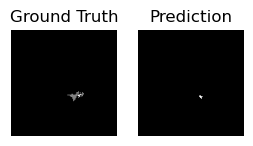

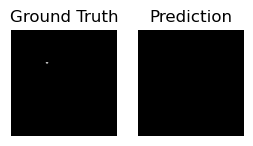

Testing Time: 0.7115058342615763 | Testing Loss: 0.0009098569862544537 | Testing Accuracy: 0.9960599769095679 | Testing Jaccard: 0.4325148382616136 | Testing Dice: 0.43922337838323355


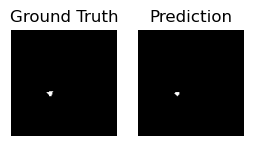

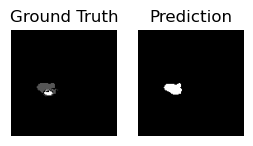

Testing Time: 0.7239045222600301 | Testing Loss: 0.006294360384345055 | Testing Accuracy: 0.9957552080294526 | Testing Jaccard: 0.5574154620887907 | Testing Dice: 0.5225741446533286


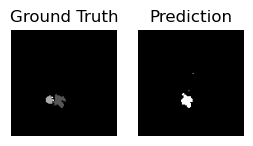

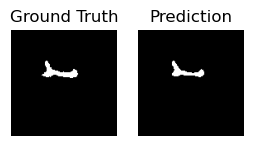

Testing Time: 0.7181790947914124 | Testing Loss: 0.01990252360701561 | Testing Accuracy: 0.9773966468371382 | Testing Jaccard: 0.34234792328758895 | Testing Dice: 0.31340359446213273


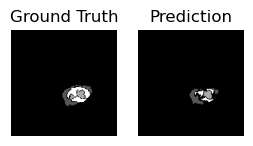

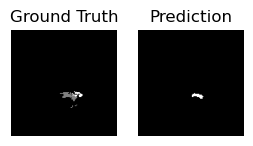

Testing Time: 0.7208465655644735 | Testing Loss: 0.0011289016110822558 | Testing Accuracy: 0.9908410641507441 | Testing Jaccard: 0.44629483470017667 | Testing Dice: 0.392625579385577


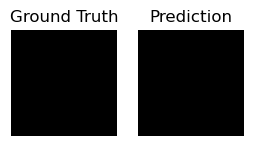

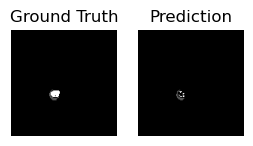

Testing Time: 0.730653981367747 | Testing Loss: 0.000477260269690305 | Testing Accuracy: 0.9960042314668764 | Testing Jaccard: 0.3557349552881698 | Testing Dice: 0.3209432041409854


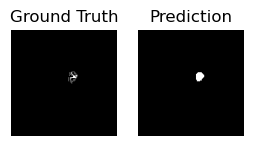

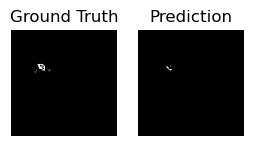

Testing Time: 0.7143172184626262 | Testing Loss: 0.0008117398247122765 | Testing Accuracy: 0.9954606116753756 | Testing Jaccard: 0.3824933122757491 | Testing Dice: 0.2710012563797831


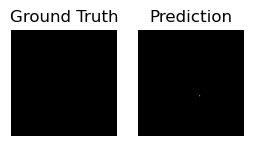

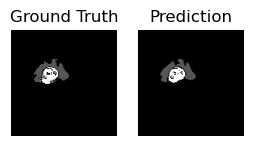

Testing Time: 0.7315114219983418 | Testing Loss: 0.000599439546931535 | Testing Accuracy: 0.9943717444882083 | Testing Jaccard: 0.6641349007348325 | Testing Dice: 0.5384236580338859


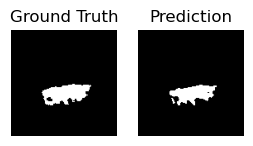

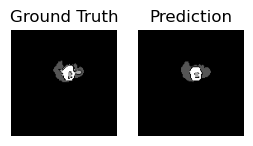

Testing Time: 0.716025729974111 | Testing Loss: 0.001280108466744423 | Testing Accuracy: 0.9906461585518449 | Testing Jaccard: 0.6789826724017215 | Testing Dice: 0.6283082405778466


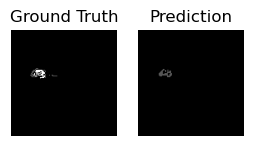

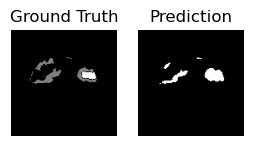

Testing Time: 0.736526902516683 | Testing Loss: 0.0015331435715779662 | Testing Accuracy: 0.9872851559487043 | Testing Jaccard: 0.49316078787254286 | Testing Dice: 0.5096921360164456


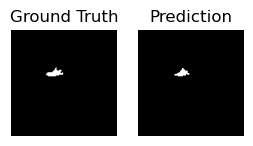

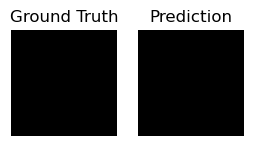

Testing Time: 0.7146119991938273 | Testing Loss: 0.000497488072142005 | Testing Accuracy: 0.9976615394090789 | Testing Jaccard: 0.36020789584334634 | Testing Dice: 0.4309352725263498


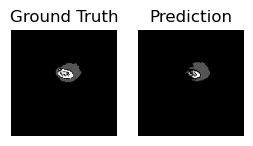

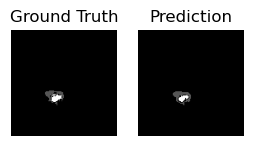

Testing Time: 0.7234535654385884 | Testing Loss: 0.003724553855136037 | Testing Accuracy: 0.9924214677960953 | Testing Jaccard: 0.5141193753163914 | Testing Dice: 0.4416664684707586


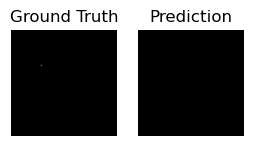

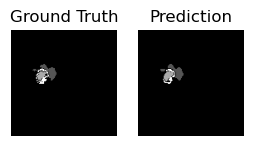

Testing Time: 0.7233618497848511 | Testing Loss: 0.0006406251341104507 | Testing Accuracy: 0.9960221351127044 | Testing Jaccard: 0.7162892686798273 | Testing Dice: 0.6316504353839817


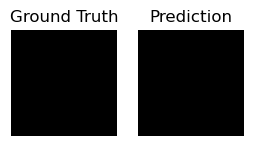

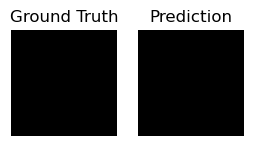

Testing Time: 0.7129556576410929 | Testing Loss: 0.000785046024248004 | Testing Accuracy: 0.9947119137589369 | Testing Jaccard: 0.12735151746918072 | Testing Dice: 0.08690347070489586


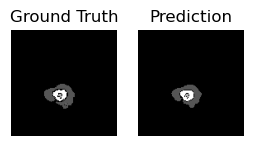

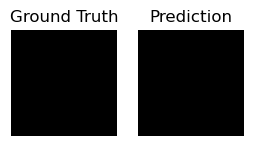

Testing Time: 0.7113356550534566 | Testing Loss: 0.004764660261571407 | Testing Accuracy: 0.9975276689664118 | Testing Jaccard: 0.5780441096543324 | Testing Dice: 0.5439232225184304


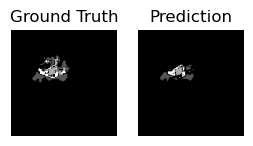

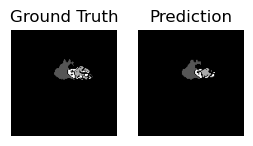

Testing Time: 0.7238677422205607 | Testing Loss: 0.0006270830635912716 | Testing Accuracy: 0.989776611026069 | Testing Jaccard: 0.6322372282653966 | Testing Dice: 0.5720698963704641


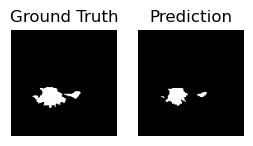

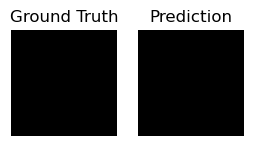

Testing Time: 0.7414138714472452 | Testing Loss: 0.00045283965300768614 | Testing Accuracy: 0.9922835283430121 | Testing Jaccard: 0.46757355730230055 | Testing Dice: 0.5297410323261992


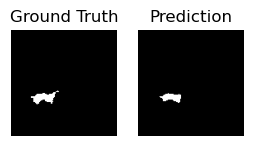

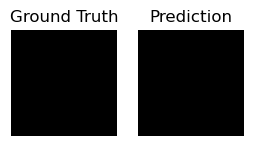

Testing Time: 0.7541329940160115 | Testing Loss: 0.01904570497572422 | Testing Accuracy: 0.991987304384769 | Testing Jaccard: 0.4312730566346365 | Testing Dice: 0.4502697356806372


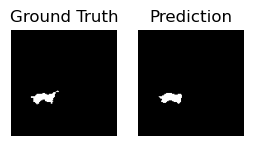

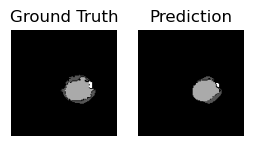

Testing Time: 0.7370812972386678 | Testing Loss: 0.0032859500497579575 | Testing Accuracy: 0.9903869625883829 | Testing Jaccard: 0.6966262231112001 | Testing Dice: 0.5884917982951733


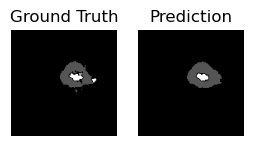

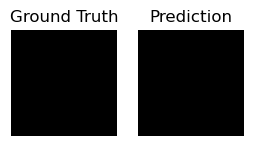

Testing Time: 0.7301065603892009 | Testing Loss: 0.0031419142615050077 | Testing Accuracy: 0.9931144202698423 | Testing Jaccard: 0.7586898609757412 | Testing Dice: 0.7366996800152837


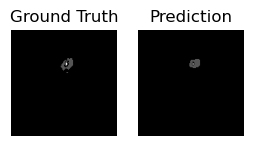

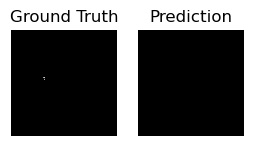

Testing Time: 0.7290738821029663 | Testing Loss: 0.0029168676119297743 | Testing Accuracy: 0.9968082679249641 | Testing Jaccard: 0.34309861910468303 | Testing Dice: 0.3685641938207169


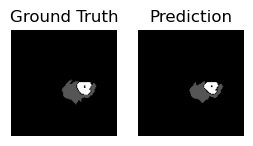

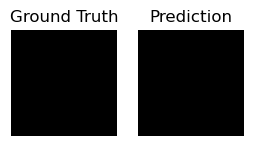

Testing Time: 0.7297417362531026 | Testing Loss: 0.002051158342510462 | Testing Accuracy: 0.9951159664931895 | Testing Jaccard: 0.7354729713332652 | Testing Dice: 0.6773772274244911


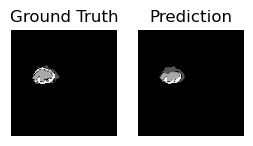

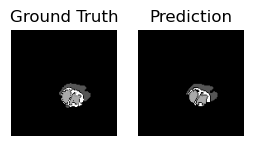

Testing Time: 0.7219064354896545 | Testing Loss: 0.005966267082840204 | Testing Accuracy: 0.9923303219627898 | Testing Jaccard: 0.6123198806699519 | Testing Dice: 0.47366286213182157


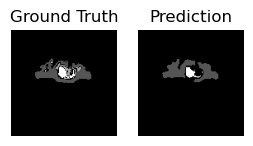

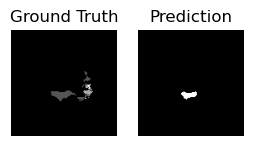

Testing Time: 0.711987026532491 | Testing Loss: 0.002588561736047268 | Testing Accuracy: 0.9870125322508706 | Testing Jaccard: 0.6134100330158386 | Testing Dice: 0.6506502035859201


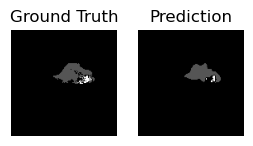

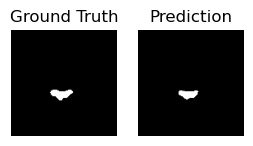

Testing Time: 0.7174300909042358 | Testing Loss: 0.0015391705092042685 | Testing Accuracy: 0.9903641761300567 | Testing Jaccard: 0.6027322191408973 | Testing Dice: 0.6645991541137841


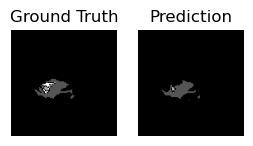

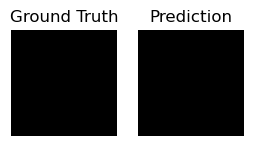

Testing Time: 0.70349174340566 | Testing Loss: 0.005386482458561659 | Testing Accuracy: 0.9961389157116275 | Testing Jaccard: 0.4363392577819377 | Testing Dice: 0.5182798385926437


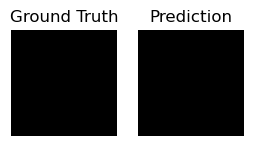

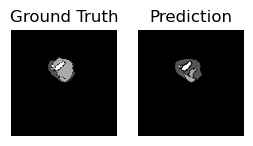

Testing Time: 0.7109404444694519 | Testing Loss: 0.0005811579758301377 | Testing Accuracy: 0.9924414059471307 | Testing Jaccard: 0.5949171826802876 | Testing Dice: 0.5082309253040417


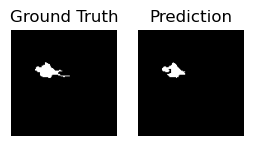

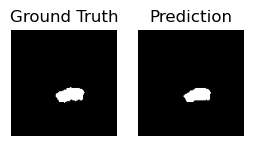

Testing Time: 0.7126238505045573 | Testing Loss: 0.00048704794608056545 | Testing Accuracy: 0.9935331214415887 | Testing Jaccard: 0.5865653437162919 | Testing Dice: 0.5981827311887443


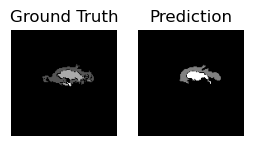

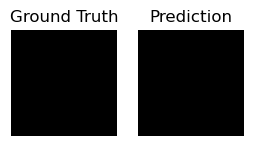

Testing Time: 0.712742292881012 | Testing Loss: 0.0030142334289848804 | Testing Accuracy: 0.9913403317287165 | Testing Jaccard: 0.5529428888130287 | Testing Dice: 0.5223732904084212


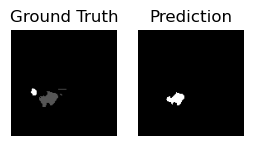

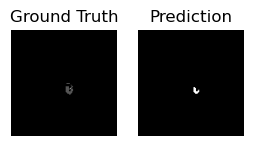

Testing Time: 0.7259186665217082 | Testing Loss: 0.0005264824721962214 | Testing Accuracy: 0.9947668453995459 | Testing Jaccard: 0.4048238777833429 | Testing Dice: 0.4657533092673172


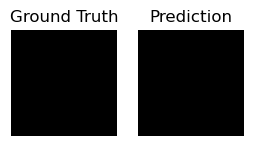

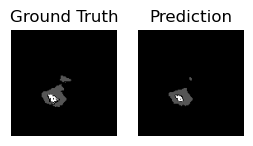

Testing Time: 0.7174139539400737 | Testing Loss: 0.0007357136928476393 | Testing Accuracy: 0.9968135576385049 | Testing Jaccard: 0.4910646472143407 | Testing Dice: 0.5141593071361246


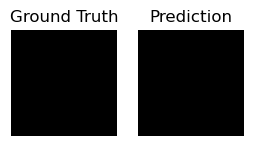

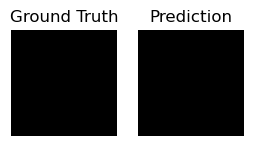

Testing Time: 0.7296220223108928 | Testing Loss: 0.0006237651687115431 | Testing Accuracy: 0.9985827633671306 | Testing Jaccard: 0.173995602730053 | Testing Dice: 0.1850746285168921


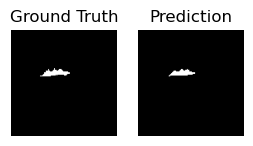

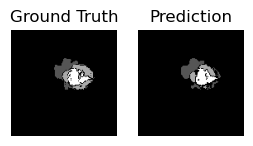

Testing Time: 0.7178463498751323 | Testing Loss: 0.0028374148532748222 | Testing Accuracy: 0.9915897620671825 | Testing Jaccard: 0.685041751150074 | Testing Dice: 0.5864051037018514


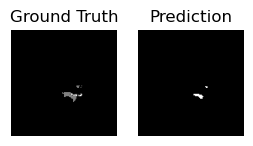

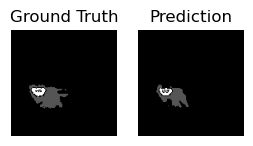

Testing Time: 0.7355659564336141 | Testing Loss: 0.002194658387452364 | Testing Accuracy: 0.9928377275615937 | Testing Jaccard: 0.6052054703840289 | Testing Dice: 0.663508781156503


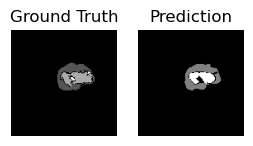

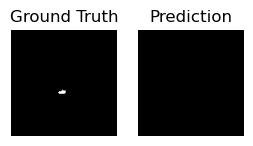

Testing Time: 0.7150388320287069 | Testing Loss: 0.0006365866865962744 | Testing Accuracy: 0.9900805661041009 | Testing Jaccard: 0.7049190031797506 | Testing Dice: 0.6470173345330698


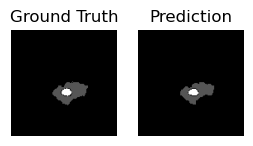

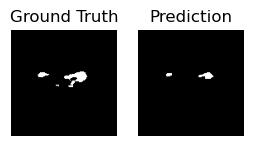

Testing Time: 0.7287304917971293 | Testing Loss: 0.0020540934056043625 | Testing Accuracy: 0.9887426754795098 | Testing Jaccard: 0.6360465576886155 | Testing Dice: 0.5383218989286817


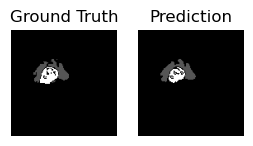

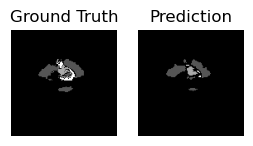

Testing Time: 0.7183517734209697 | Testing Loss: 0.0007235719822347164 | Testing Accuracy: 0.9882491045161186 | Testing Jaccard: 0.6459948886547856 | Testing Dice: 0.610886168397756


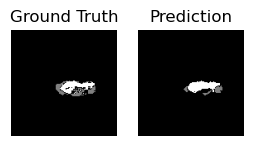

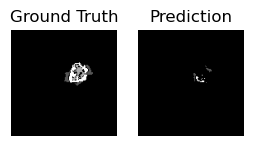

Testing Time: 0.7241175969441732 | Testing Loss: 0.0014367842813953757 | Testing Accuracy: 0.9843196611579428 | Testing Jaccard: 0.3222807041163661 | Testing Dice: 0.2906900509117053


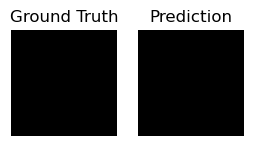

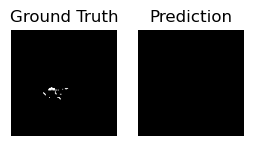

Testing Time: 0.7433681130409241 | Testing Loss: 0.0005515537923201919 | Testing Accuracy: 0.9923388668846618 | Testing Jaccard: 0.1212697349185279 | Testing Dice: 0.12289871609357648


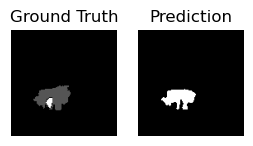

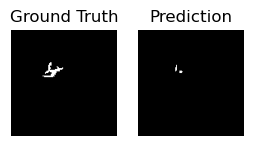

Testing Time: 0.7198525667190552 | Testing Loss: 0.0004882150096818805 | Testing Accuracy: 0.9888301592034409 | Testing Jaccard: 0.4264520705811617 | Testing Dice: 0.42836230605214437


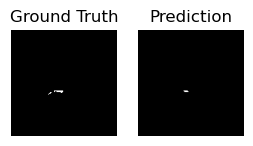

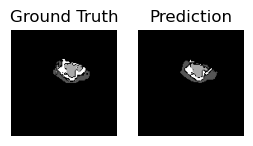

Testing Time: 0.7442134340604146 | Testing Loss: 0.0005899275420233607 | Testing Accuracy: 0.9921577959211756 | Testing Jaccard: 0.6648404756063333 | Testing Dice: 0.49538765849414074


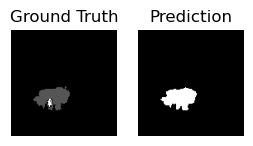

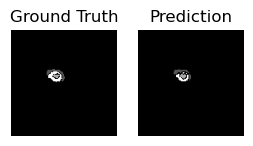

Testing Time: 0.7273877104123433 | Testing Loss: 0.0004700429562944919 | Testing Accuracy: 0.9932047523010645 | Testing Jaccard: 0.6671369095459397 | Testing Dice: 0.5979959399954234


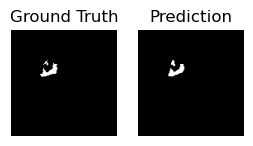

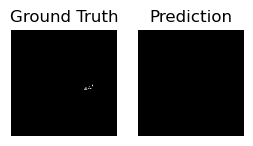

Testing Time: 0.7418389717737833 | Testing Loss: 0.0007417853339575231 | Testing Accuracy: 0.9947208655818516 | Testing Jaccard: 0.34623333441720505 | Testing Dice: 0.39764930684099464


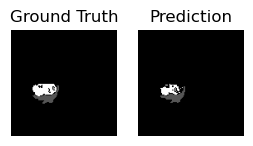

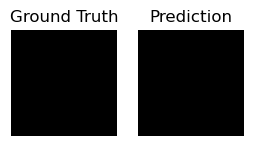

Testing Time: 0.7209566354751586 | Testing Loss: 0.0004874020232819021 | Testing Accuracy: 0.9962162269095203 | Testing Jaccard: 0.539782925476143 | Testing Dice: 0.46985087365095174


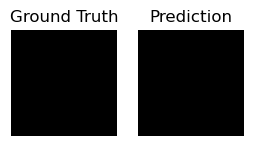

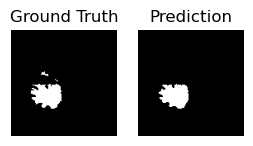

Testing Time: 0.7339442173639933 | Testing Loss: 0.006629410199820995 | Testing Accuracy: 0.9949552405817809 | Testing Jaccard: 0.7420155149461237 | Testing Dice: 0.7118872624166653


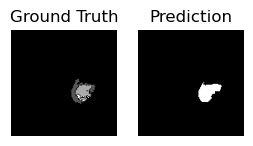

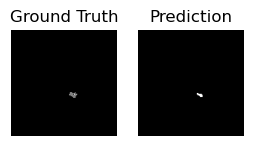

Testing Time: 0.7175179918607076 | Testing Loss: 0.0006662124069407582 | Testing Accuracy: 0.9940865068580867 | Testing Jaccard: 0.5771638123586936 | Testing Dice: 0.4854193654659731


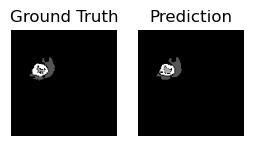

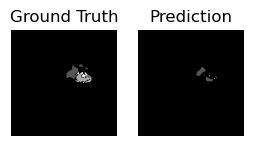

Testing Time: 0.7482056101163228 | Testing Loss: 0.01834704540669918 | Testing Accuracy: 0.9926375322491543 | Testing Jaccard: 0.578285189404122 | Testing Dice: 0.543363394818877


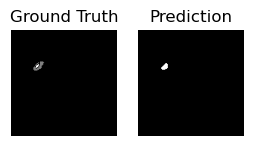

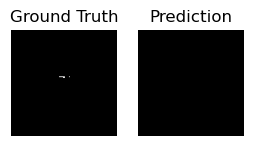

Testing Time: 0.7234346787134807 | Testing Loss: 0.0009292383911088109 | Testing Accuracy: 0.9958919267794103 | Testing Jaccard: 0.28538106429762633 | Testing Dice: 0.21484678622871448


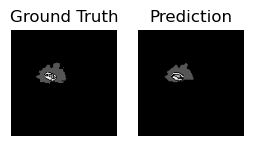

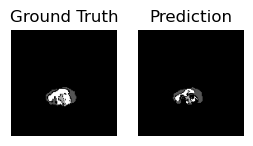

Testing Time: 0.7320692658424377 | Testing Loss: 0.0005542097496800125 | Testing Accuracy: 0.9921476233951374 | Testing Jaccard: 0.5228738204931593 | Testing Dice: 0.48535177660265894


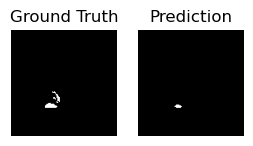

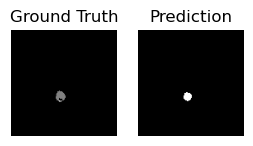

Testing Time: 0.7431844353675843 | Testing Loss: 0.0004639127873815596 | Testing Accuracy: 0.9934761552957728 | Testing Jaccard: 0.32185879393279054 | Testing Dice: 0.3398460818455668


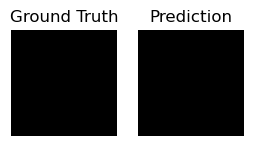

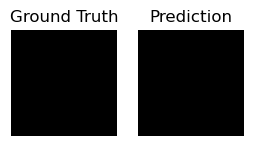

Testing Time: 0.7357054511706035 | Testing Loss: 0.0014200572622939944 | Testing Accuracy: 0.9923636878481951 | Testing Jaccard: 0.049665634426457 | Testing Dice: 0.05623575779541356


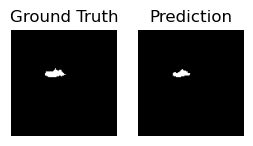

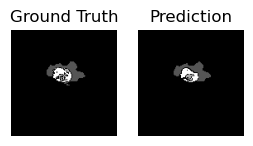

Testing Time: 0.7194109121958415 | Testing Loss: 0.003925797529518604 | Testing Accuracy: 0.9953706865451949 | Testing Jaccard: 0.6794621652083959 | Testing Dice: 0.5941080075219147


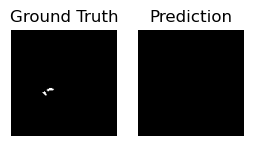

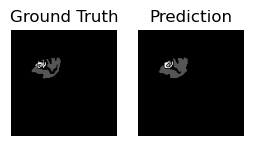

Testing Time: 0.7438291112581888 | Testing Loss: 0.0005011914181523025 | Testing Accuracy: 0.9935465491759599 | Testing Jaccard: 0.4967153100265445 | Testing Dice: 0.5142541728262366


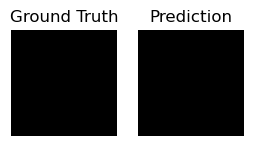

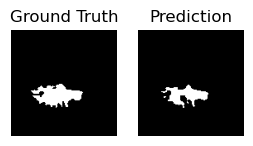

Testing Time: 0.7304845253626505 | Testing Loss: 0.0005191387608647346 | Testing Accuracy: 0.9895170081615652 | Testing Jaccard: 0.5636322453008182 | Testing Dice: 0.6095437376081482


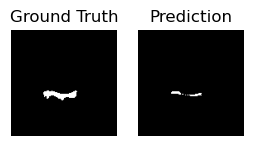

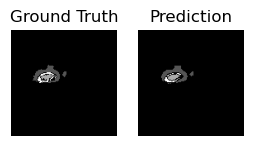

Testing Time: 0.7423022270202637 | Testing Loss: 0.0005977096152491868 | Testing Accuracy: 0.9937402340717347 | Testing Jaccard: 0.5486903488909743 | Testing Dice: 0.558167553780492


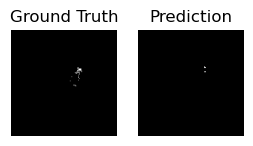

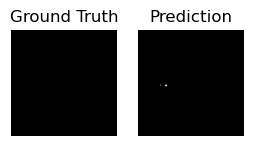

Testing Time: 0.7190078139305115 | Testing Loss: 0.000895535631570965 | Testing Accuracy: 0.9925463864158482 | Testing Jaccard: 0.22409295629096845 | Testing Dice: 0.2035283535451591


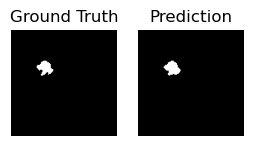

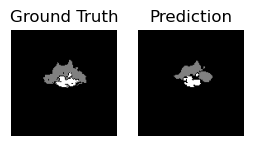

Testing Time: 0.7195732514063518 | Testing Loss: 0.005882109049707651 | Testing Accuracy: 0.9893424476147429 | Testing Jaccard: 0.6527509586190713 | Testing Dice: 0.52954430683536


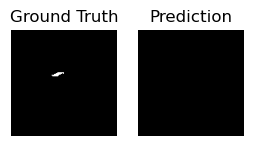

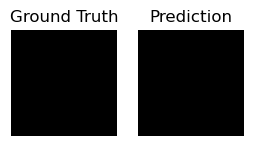

Testing Time: 0.7229670802752177 | Testing Loss: 0.0005231889081187546 | Testing Accuracy: 0.9923384599836195 | Testing Jaccard: 0.31068433132548895 | Testing Dice: 0.3444987151651128


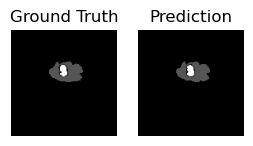

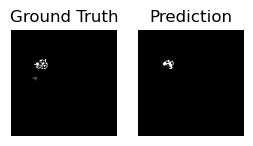

Testing Time: 0.743235715230306 | Testing Loss: 0.0005524706793949008 | Testing Accuracy: 0.9974117021695721 | Testing Jaccard: 0.5964563265358174 | Testing Dice: 0.5280676020522796


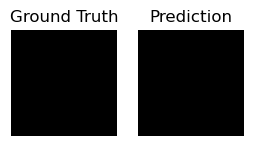

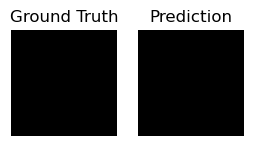

Testing Time: 0.7170109430948893 | Testing Loss: 0.0013565262779593468 | Testing Accuracy: 0.99867228159627 | Testing Jaccard: 0.2399802581452199 | Testing Dice: 0.23170216150551753


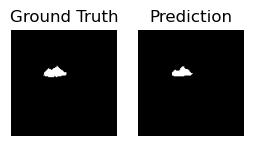

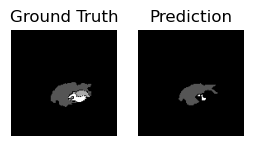

Testing Time: 0.7368712703386943 | Testing Loss: 0.0005686949007213116 | Testing Accuracy: 0.9895129391511492 | Testing Jaccard: 0.5009517395840608 | Testing Dice: 0.5023161354422515


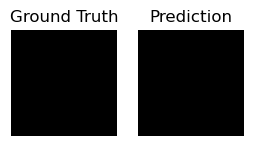

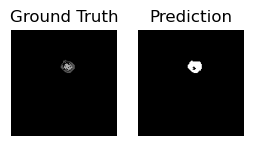

Testing Time: 0.7210174878438314 | Testing Loss: 0.001239665551111102 | Testing Accuracy: 0.9972517900602459 | Testing Jaccard: 0.4913957898130179 | Testing Dice: 0.48474431287597836


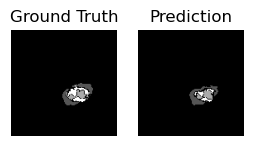

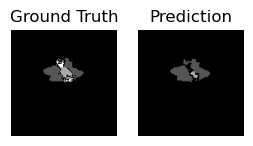

Testing Time: 0.7452495574951172 | Testing Loss: 0.0010537535417824984 | Testing Accuracy: 0.9889705400627734 | Testing Jaccard: 0.6779362870397323 | Testing Dice: 0.650361225099263


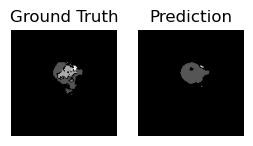

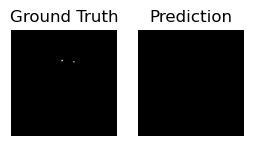

Testing Time: 0.7337520798047383 | Testing Loss: 0.0005657504661940038 | Testing Accuracy: 0.9885489905837352 | Testing Jaccard: 0.4800660636877838 | Testing Dice: 0.533766997272494


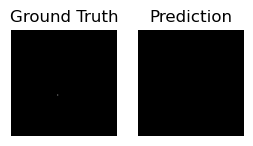

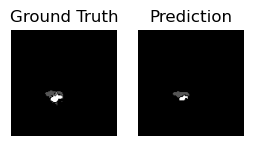

Testing Time: 0.7156795422236125 | Testing Loss: 0.0004660449340008199 | Testing Accuracy: 0.997489827169548 | Testing Jaccard: 0.3416441932247002 | Testing Dice: 0.3347672979996716


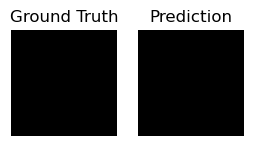

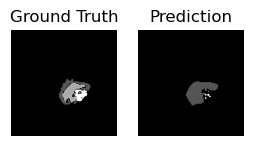

Testing Time: 0.7331806699434916 | Testing Loss: 0.0013096269685775042 | Testing Accuracy: 0.9909761552965367 | Testing Jaccard: 0.45732837500537915 | Testing Dice: 0.4389753957541551


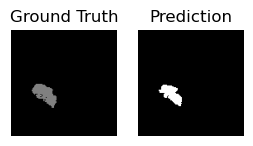

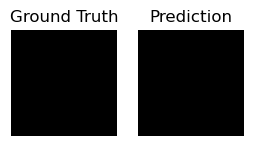

Testing Time: 0.7196798960367838 | Testing Loss: 0.0006156543968245387 | Testing Accuracy: 0.9935734046447018 | Testing Jaccard: 0.45667150720379085 | Testing Dice: 0.4886535795633908


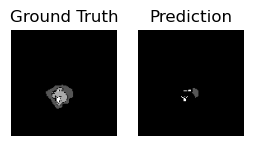

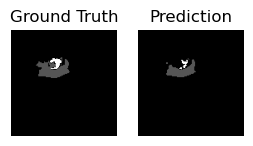

Testing Time: 0.734916603565216 | Testing Loss: 0.009896161034703255 | Testing Accuracy: 0.9869327796467288 | Testing Jaccard: 0.3419937285328345 | Testing Dice: 0.38122234521027976


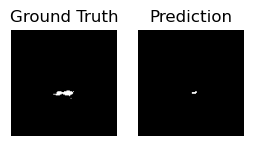

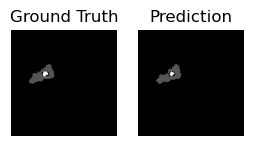

Testing Time: 0.7189865708351135 | Testing Loss: 0.00048487388994544744 | Testing Accuracy: 0.9957462562065388 | Testing Jaccard: 0.5124863109246104 | Testing Dice: 0.566868325429054


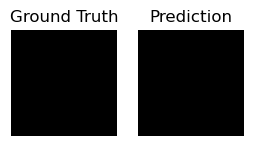

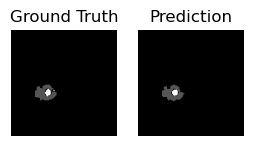

Testing Time: 0.7354016423225402 | Testing Loss: 0.002700221259146929 | Testing Accuracy: 0.9944217933163183 | Testing Jaccard: 0.6158273200128722 | Testing Dice: 0.5465802026447949


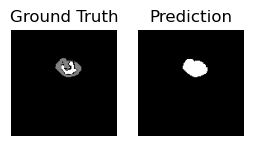

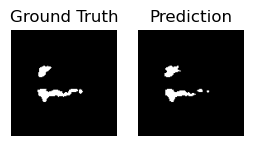

Testing Time: 0.7129202326138814 | Testing Loss: 0.0019243888091295958 | Testing Accuracy: 0.991269124046447 | Testing Jaccard: 0.5306359518882668 | Testing Dice: 0.4719025314904479


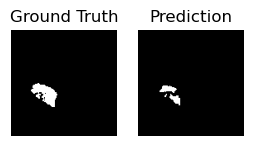

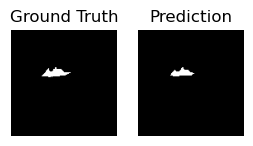

Testing Time: 0.7108137925465902 | Testing Loss: 0.0008150499779731035 | Testing Accuracy: 0.9904512529529463 | Testing Jaccard: 0.32368397656055614 | Testing Dice: 0.35982159454628315


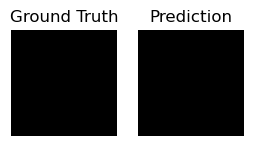

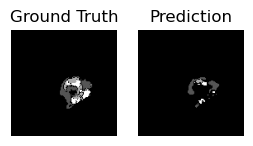

Testing Time: 0.7177716930707295 | Testing Loss: 0.0013058788608759642 | Testing Accuracy: 0.9888468421461443 | Testing Jaccard: 0.4334400518184477 | Testing Dice: 0.4578612971658472


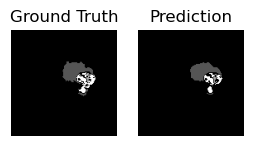

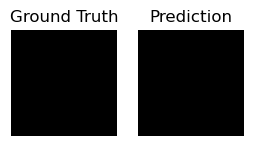

Testing Time: 0.7193320949872335 | Testing Loss: 0.0015538698062300682 | Testing Accuracy: 0.9933011878479098 | Testing Jaccard: 0.7339867294915555 | Testing Dice: 0.627111051610042


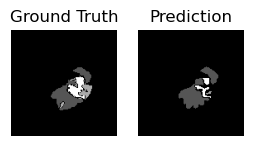

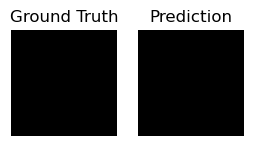

Testing Time: 0.7231969118118287 | Testing Loss: 0.0023658243007957935 | Testing Accuracy: 0.9892338050366514 | Testing Jaccard: 0.7064700436448699 | Testing Dice: 0.6593056603123336


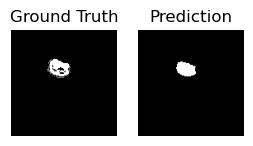

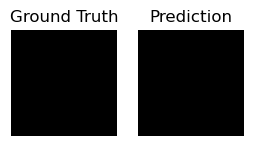

Testing Time: 0.7269496401151021 | Testing Loss: 0.0016418389277532697 | Testing Accuracy: 0.9928731279522075 | Testing Jaccard: 0.4450589363215327 | Testing Dice: 0.39847307449275887


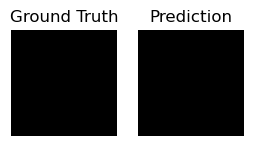

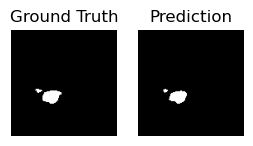

Testing Time: 0.7408617615699769 | Testing Loss: 0.00045068905455991626 | Testing Accuracy: 0.9937121578998672 | Testing Jaccard: 0.4922602211739373 | Testing Dice: 0.46402326891226475


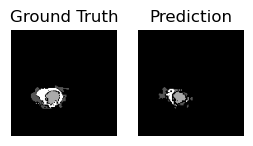

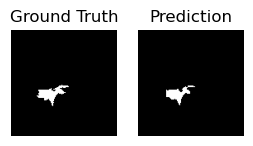

Testing Time: 0.7063079277674357 | Testing Loss: 0.000608231988735497 | Testing Accuracy: 0.9850646969650066 | Testing Jaccard: 0.3292185595135123 | Testing Dice: 0.26569226668283097


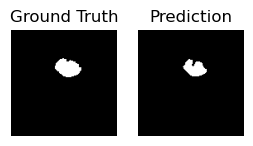

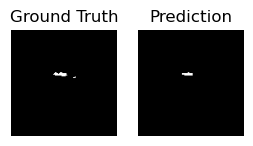

Testing Time: 0.7233064651489258 | Testing Loss: 0.0004555592895485461 | Testing Accuracy: 0.9894262692293004 | Testing Jaccard: 0.4281274148120978 | Testing Dice: 0.3878494397085719


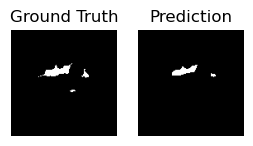

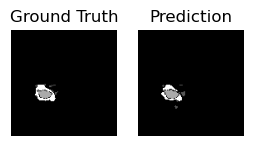

Testing Time: 0.7168352961540222 | Testing Loss: 0.001042161718942225 | Testing Accuracy: 0.9930676266500641 | Testing Jaccard: 0.5409066008321326 | Testing Dice: 0.44409384864594725


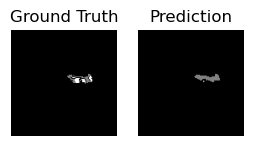

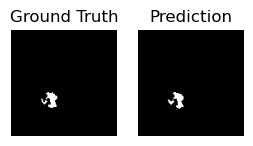

Testing Time: 0.7349560737609864 | Testing Loss: 0.0004621582047548145 | Testing Accuracy: 0.9964054358938376 | Testing Jaccard: 0.5308313976956941 | Testing Dice: 0.5819923678884881


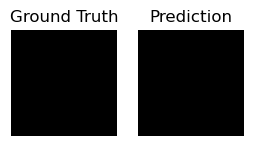

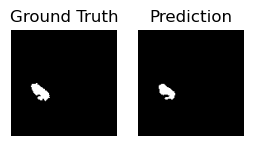

Testing Time: 0.7236554503440857 | Testing Loss: 0.0005433107144199312 | Testing Accuracy: 0.9950154619359278 | Testing Jaccard: 0.4008726243331118 | Testing Dice: 0.39631715009057067


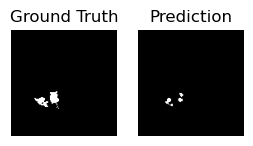

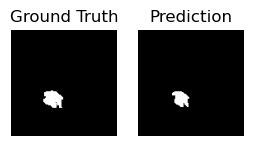

Testing Time: 0.734730605284373 | Testing Loss: 0.00046561696217395365 | Testing Accuracy: 0.995653482769067 | Testing Jaccard: 0.5321105195838931 | Testing Dice: 0.5580903612984134


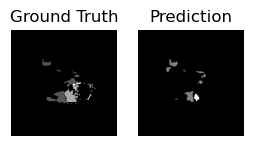

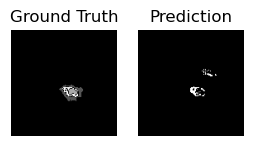

Testing Time: 0.7348093907038371 | Testing Loss: 0.0009723543189466 | Testing Accuracy: 0.9875065101153033 | Testing Jaccard: 0.28824231902506736 | Testing Dice: 0.32919115059740245


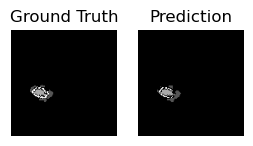

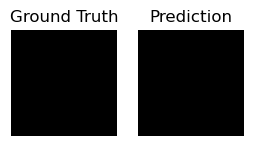

Testing Time: 0.752417798837026 | Testing Loss: 0.0004430108529049903 | Testing Accuracy: 0.9982979326380517 | Testing Jaccard: 0.542051685410916 | Testing Dice: 0.49880453944781644


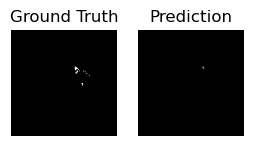

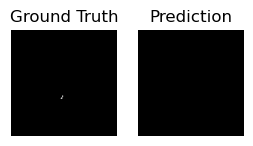

Testing Time: 0.7139212886492411 | Testing Loss: 0.0008537007379345596 | Testing Accuracy: 0.9948217770401542 | Testing Jaccard: 0.3642124501147443 | Testing Dice: 0.3676899847788331


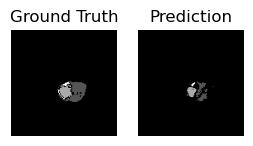

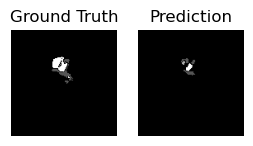

Testing Time: 0.7121088822682698 | Testing Loss: 0.0014676665887236595 | Testing Accuracy: 0.9890958655835684 | Testing Jaccard: 0.40363546972905356 | Testing Dice: 0.3805026135059221


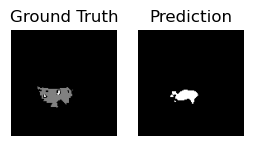

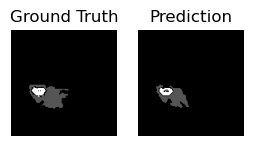

Testing Time: 0.7119756619135539 | Testing Loss: 0.0023788060061633587 | Testing Accuracy: 0.9864567054281241 | Testing Jaccard: 0.5055841138912286 | Testing Dice: 0.5811842237957304


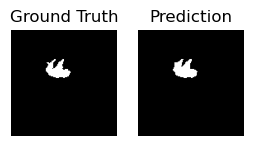

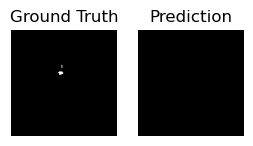

Testing Time: 0.7285862048467 | Testing Loss: 0.0007165723363868892 | Testing Accuracy: 0.9911336259996129 | Testing Jaccard: 0.5089735127120002 | Testing Dice: 0.47562238270787494


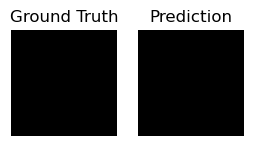

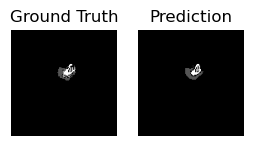

Testing Time: 0.7168816645940145 | Testing Loss: 0.0005132275400683284 | Testing Accuracy: 0.9963977047740478 | Testing Jaccard: 0.39925791476701405 | Testing Dice: 0.3426214592845502


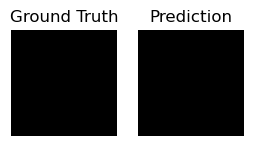

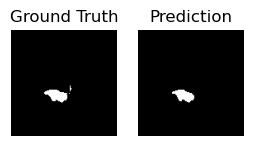

Testing Time: 0.7137296160062154 | Testing Loss: 0.0010115890763700008 | Testing Accuracy: 0.9975882972216014 | Testing Jaccard: 0.4890665190587993 | Testing Dice: 0.5380842545627907


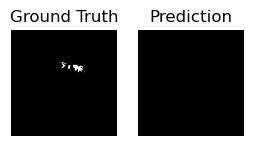

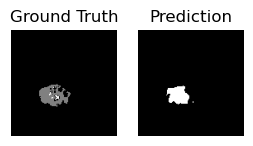

Testing Time: 0.7118932088216146 | Testing Loss: 0.0013504776870831847 | Testing Accuracy: 0.9938684078998202 | Testing Jaccard: 0.554758206379938 | Testing Dice: 0.6332882035125813


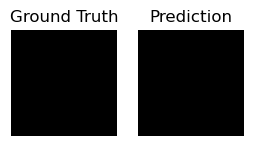

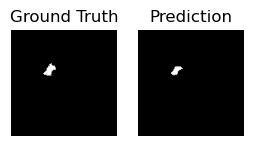

Testing Time: 0.7002481142679851 | Testing Loss: 0.0004992276080884039 | Testing Accuracy: 0.9964774573781904 | Testing Jaccard: 0.410569738499121 | Testing Dice: 0.4520805006835544


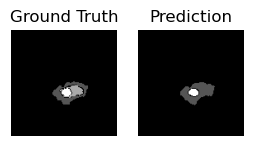

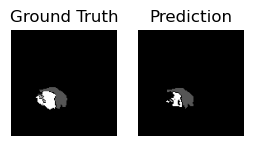

Testing Time: 0.694215448697408 | Testing Loss: 0.0006665824330411851 | Testing Accuracy: 0.9910188799058981 | Testing Jaccard: 0.6721740000253333 | Testing Dice: 0.5330817109629689


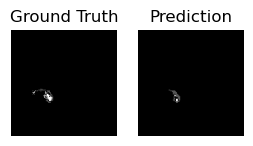

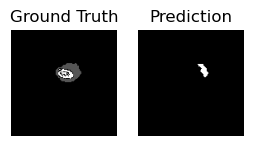

Testing Time: 0.7105315407117208 | Testing Loss: 0.0009260228835046291 | Testing Accuracy: 0.9872713213132914 | Testing Jaccard: 0.14902900622011228 | Testing Dice: 0.18683221426018232


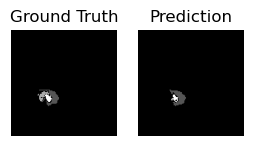

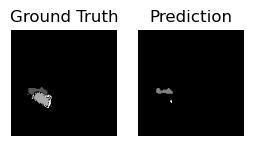

Testing Time: 0.6962490638097127 | Testing Loss: 0.0004426301165949553 | Testing Accuracy: 0.9930965166240141 | Testing Jaccard: 0.3657156374307944 | Testing Dice: 0.3785032718417465


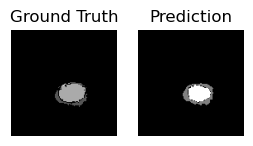

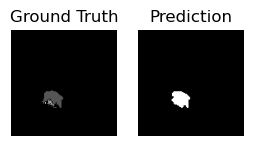

Testing Time: 0.7161788860956828 | Testing Loss: 0.0006026913761161268 | Testing Accuracy: 0.9850736487879209 | Testing Jaccard: 0.5056010123786076 | Testing Dice: 0.45599461360046867


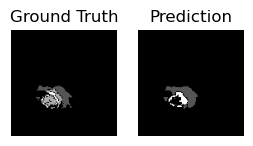

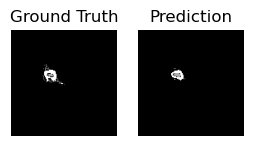

Testing Time: 0.6973156730333964 | Testing Loss: 0.002000583801418543 | Testing Accuracy: 0.9904451494373235 | Testing Jaccard: 0.5757157183204841 | Testing Dice: 0.5146497441085072


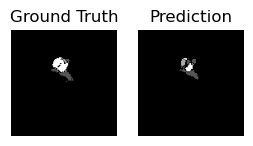

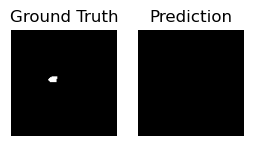

Testing Time: 0.7317148605982463 | Testing Loss: 0.0006240223883651197 | Testing Accuracy: 0.988671874698281 | Testing Jaccard: 0.44747415238503635 | Testing Dice: 0.4548605242919091


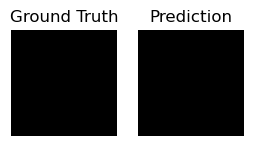

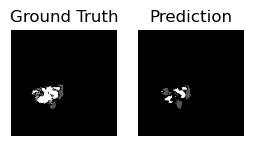

Testing Time: 0.699247666200002 | Testing Loss: 0.0013125217519700527 | Testing Accuracy: 0.9914969886297106 | Testing Jaccard: 0.3474794143068855 | Testing Dice: 0.23497564839614435


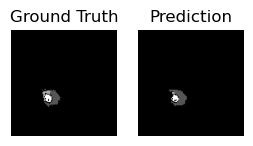

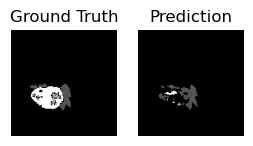

Testing Time: 0.7224902947743733 | Testing Loss: 0.0029339627362787724 | Testing Accuracy: 0.9822534176689904 | Testing Jaccard: 0.43976554957226965 | Testing Dice: 0.38527789436299853


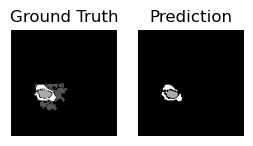

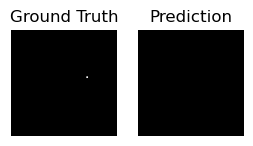

Testing Time: 0.7107126275698344 | Testing Loss: 0.00046294063213281333 | Testing Accuracy: 0.9908671058174027 | Testing Jaccard: 0.4227744194839756 | Testing Dice: 0.3305241916643917


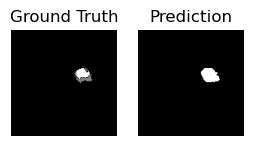

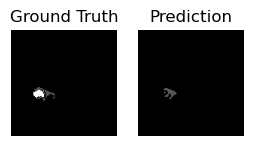

Testing Time: 0.7105207920074463 | Testing Loss: 0.007690140046179295 | Testing Accuracy: 0.9909785967027854 | Testing Jaccard: 0.3546397804356818 | Testing Dice: 0.3064637371891026


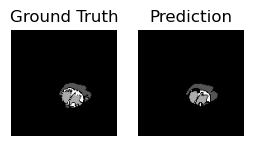

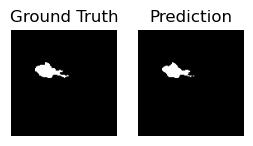

Testing Time: 0.7257949272791545 | Testing Loss: 0.0006165823433548212 | Testing Accuracy: 0.9933312985249841 | Testing Jaccard: 0.734246756353912 | Testing Dice: 0.6541287596230059


In [30]:
model.eval()
test_loss = []
test_acc = []
test_jacc = []
test_dice = []

for batch in test_dl:
    Test_acc=0
    Test_iou=0
    Test_dice=0
    start = time.time()
    img, label = batch
    img = img.float()
    for i in range(0,75):
        pred = model(img[:,:,:,:,i])
       # print(i)
       # print(np.shape(pred))
        #print(np.shape(label))
        label_slice = (label[:,:,:,:,i].float())
        loss = criteria(pred,label_slice)
        pred = F.softmax(pred, dim=1)
        #put 1 if elements of pred is greater than 0.5 else 0
        pred = torch.where(pred>=0.5, torch.tensor(1), torch.tensor(0))
        test_loss.append(loss.item())
        
        if(i==40):
            for j in range(len(batch)):
                new_lable = torch.zeros((128,128))
                new_lable[:,:] = torch.from_numpy(np.argmax(label_slice.cpu().numpy(),axis=1))[j,:,:]
                new_pred = torch.zeros((128, 128))
                new_pred =  torch.from_numpy(np.argmax((pred.cpu()).numpy(),axis=1))[j,:,:]
                fig, ax = plt.subplots(1,2, figsize=(3,3))
                ax[0].imshow(new_lable, cmap="gray")
                ax[0].set_title("Ground Truth")
                ax[1].imshow(new_pred.detach().numpy(), cmap="gray")
                ax[1].set_title("Prediction")
                [axi.set_axis_off() for axi in ax.ravel()]
                plt.show()
        Test_acc = Test_acc+cal_accuracy(pred, label_slice)
        Test_iou = Test_iou+cal_iou(pred, label_slice)
        Test_dice =Test_dice + calculate_dice(pred, label_slice)
    #print(Test_acc)
    test_acc.append(Test_acc/75)
    test_jacc.append(Test_iou/75)
    test_dice.append(Test_dice/75)

    end = time.time()
    testing_time = (end - start)/60
    print("Testing Time: {} | Testing Loss: {} | Testing Accuracy: {} | Testing Jaccard: {} | Testing Dice: {}".format(testing_time, loss.item(),test_acc[-1],test_jacc[-1],test_dice[-1]))
